# Plots for MacNeil *et al.* 2020 *Global status and conservation potential of reef sharks*

In [1]:
# Import python packages
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
#import theano as T
#import theano.tensor as tt
import seaborn as sns
import matplotlib as mp
mp.rcParams['pdf.fonttype'] = 42
mp.rcParams['ps.fonttype'] = 42
import numpy.random as npr
import matplotlib.patches as mpatches
from scipy.interpolate import interp1d
import mpl_toolkits as mpl
import datetime as dt
from scipy.stats.kde import gaussian_kde
import matplotlib.path as mpath
import scipy as sp
from theano import shared
import sqlite3
import cmocean as co
#import joypy as jp
from matplotlib.patches import Rectangle
import palettable
import os
import pdb
#mp.pyplot.style.use('ggplot')
mp.pyplot.style.use('seaborn-darkgrid')

In [2]:
os.environ['PROJ_LIB'] = '/anaconda3/share/proj'

In [3]:
from mpl_toolkits.basemap import Basemap as bm

In [4]:
# Helper functions
def indexall(L):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    return poo,Ix

def subindexall(short,long):
    poo = []
    out = []
    for s,l in zip(short,long):
        if not l in poo:
            poo.append(l)
            out.append(s)
    return indexall(out)

match = lambda a, b: np.array([ b.index(x) if x in b else None for x in a ])
grep = lambda s, l: np.array([i for i in l if s in i])
npm = np.median

# Function to standardize covariates
def stdize(x):
    return (x-np.mean(x))/(2*np.std(x))

def SMA(array):
    return npr.choice(array)

def SMX(matrix,indx):
    return npr.choice(matrix[matrix.columns[indx]].values)

def gelplot(pj,vector,posy,csize=40,lwd50=7,lwd95=1,lui=5,uli=95):
    if np.percentile(vector,lui)<0 and 0<np.percentile(vector,uli):
        pj.plot(np.median(vector),posy,'.',markersize=csize,c='grey')
        pj.plot((np.percentile(vector,lui),np.percentile(vector,uli)),(posy,posy),linewidth=lwd95,c='grey')
        pj.plot((np.percentile(vector,25),np.percentile(vector,75)),(posy,posy),linewidth=lwd50,c='grey')
    else:
        pj.plot(np.median(vector),posy,'.',markersize=csize,c='black')
        pj.plot((np.percentile(vector,lui),np.percentile(vector,uli)),(posy,posy),linewidth=lwd95,c='black')
        pj.plot((np.percentile(vector,25),np.percentile(vector,75)),(posy,posy),linewidth=lwd50,c='black')
        
    if np.percentile(vector,25)<0 and 0<np.percentile(vector,75):
        pj.plot(np.median(vector),posy,'.',markersize=csize,c='white')
def invlogit(x):
    return np.exp(x)/(1+np.exp(x))

# Summary functions
def CB(new,vec,obs,base,indx,valx=0):
    maxd = (base-obs)
    newd = (base-new)
    return 100-(newd/maxd)[vec[indx]!=valx]*100

def CBx(new,obs,base):
    maxd = (base-obs)
    newd = (base-new)
    return 100-(newd/maxd)*100

# Function to standardize covariates
def stdize(x):
    return (x-np.mean(x))/(np.std(x)*2)

def abline(intercept,slope,col='black',alpha=1):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--',c='black',alpha=alpha)

## Import data

In [5]:
# Import FP data
fpdata = pd.read_csv('FinPrint_Set_Data.csv')
# Import location-scale data
ldata = pd.read_csv('Location_Covariates.csv')
# Grab only sharks
poo = fpdata[fpdata['functional_group'].isin(['reef_meso','apex','coastal_rover','benthic_rover', 'nocturnal_invader'])]
# Sum maxn's given set id's
tmp = poo.groupby(['set_id'], as_index=False)['maxn'].sum()
tmp.columns = ['set_id','MaxN_shark']
xdata = fpdata.merge(tmp, on=['set_id']).drop_duplicates(subset=['set_id'])

# Re-label nations
xdata.location_name[xdata.site_name=='Ashmore'] = 'Australia IOT'
xdata.location_name[xdata.site_name=='Rowley Shoals'] = 'Australia IOT'
xdata.location_name[xdata.site_name=='Scott Reef'] = 'Australia IOT'
xdata.location_name[xdata.site_name=='Houtman Abrolhos'] = 'Australia IOT'
xdata.location_name[xdata.site_name=='Cocos-Keeling'] = 'Australia IOT'
xdata.location_name[xdata.site_name=='Christmas Island'] = 'Australia IOT'
xdata.location_name[xdata.site_name=='Pedro Bank'] = 'Jamaica PB'
xdata.location_name[xdata.site_name=='Cayo Serranilla'] = 'Columbia SF'
xdata.location_name[xdata.site_name=='Old Providence Island'] = 'Columbia SF'
xdata.location_name[xdata.location_name=='Saudi Arabia'] = 'Saudi Arabia-Red Sea'
xdata.location_name[xdata.location_name=='British West Indies '] = 'Montserrat'
ldata.FP_location_name[ldata.FP_location_name=='Saudi Arabia'] = 'Saudi Arabia-Red Sea'
ldata.FP_location_name[ldata.FP_location_name=='British West Indies '] = 'Montserrat' 
xdata.location_name[xdata.site_name=='Aruba'] = 'Dutch Antilles Leeward'
xdata.location_name[xdata.site_name=='Bonaire'] = 'Dutch Antilles Leeward'
xdata.location_name[xdata.site_name=='Curacao'] = 'Dutch Antilles Leeward'
xdata.location_name[xdata.site_name=='Saba'] = 'Dutch Antilles Windward'
xdata.location_name[xdata.site_name=='Saba Bank'] = 'Dutch Antilles Windward'
xdata.location_name[xdata.site_name=='St Eustatius'] = 'Dutch Antilles Windward'
xdata.location_name[xdata.site_name=='St Maarten'] = 'Dutch Antilles Windward'


/Users/aaronmacneil/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (23,26,57,58) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/aaronmacneil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/aaronmacneil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/Users/aaronmacneil/anaconda3/lib/python3.7/site-package

In [6]:
# Cut rows with no visibility values
xdata = xdata[np.isfinite(xdata['visibility'])]
# Cut rows with no hard coral values
xdata = xdata[np.isfinite(xdata['hard_coral'])]
# Cut rows with no rugosity values
xdata = xdata[np.isfinite(xdata['substrate_relief_mean'])]

In [7]:
xdata.loc[xdata['set_id'].isin(np.array([6783,29122,33986,20819,34989,22974,10335,24488,8863,7255]))].to_csv('highlev.csv')

In [8]:
# Remove high leverage observations
xdata = xdata[xdata.set_id!=6783]
xdata = xdata[xdata.set_id!=29122]
xdata = xdata[xdata.set_id!=33986]
xdata = xdata[xdata.set_id!=20819]
xdata = xdata[xdata.set_id!=34989]
xdata = xdata[xdata.set_id!=22974]
xdata = xdata[xdata.set_id!=10335]
xdata = xdata[xdata.set_id!=24488]
xdata = xdata[xdata.set_id!=8863]
xdata = xdata[xdata.set_id!=7255]
xdata = xdata[xdata.set_id!=32874]

In [9]:
# Hierarchical levels
Reef,Ir = indexall(np.array(xdata.reef_id.values))
nreefs = len(Reef)

Site,Is = subindexall(xdata.site_name.values,xdata.reef_id.values)
nsites = len(Site)

LocationR,Ilr = subindexall(xdata.location_name.values,xdata.reef_id.values)

RegionL,Irl = subindexall(xdata.region_name.values,xdata.location_name.values)

LocationS,Ils = indexall(xdata.location_name.values)

Location,Il = subindexall(xdata.location_name.values,xdata.site_name.values)
nlocs = len(Location)

Region,Ig = subindexall(xdata.region_name.values,xdata.location_name.values)
nreg = len(Region)

Lox,Ilx = indexall(xdata.site_name.values)

In [10]:
len(Ilr)

371

In [11]:
max(xdata.mpa_area.values[np.isnan(xdata.mpa_area.values)==False])

1976000.0

In [12]:
# Lat/lon - national
Lat = np.array([np.mean(xdata.set_latitude.values[xdata.location_name.values==L]) for L in Location])
Lon = np.array([np.mean(xdata.set_longitude.values[xdata.location_name.values==L]) for L in Location])

# Location key
lkey = np.array([list(ldata.FP_location_name.values).index(l) for l in Location])
# Site key
skey = np.array([list(xdata.site_name.values).index(s) for s in Site])
# Reef key
rkey = np.array([list(xdata.reef_id.values).index(r) for r in Reef])

## Location-level covariates

# Human development index
HDI = ldata.HDI.values[lkey]

# Voice and accountability
VOICE = ldata.Voice_Accountability.values[lkey]

# Population size
POP = stdize(np.log(ldata.Population.values[lkey]))

# Total catch
CATCH = stdize(np.log(ldata.Reef_catch_tonnes.values[lkey]))

# Shark catch
SCAT = stdize(np.log(ldata.Shark_catch_tonnes.values[lkey]+1))

# Beche de Mer
BDM = stdize(np.log(ldata.Bechedemer_catch_tonnes.values[lkey]+1))

# Tax haven
TAX = ldata.tax_haven.values[lkey]

# Shark sanctuary
SSA = ldata.Shark_Sanctuary.values[lkey]

# Coastline length
CLN = stdize(ldata.CoastLength.values[lkey])

# Site type
STY,Isty = indexall(xdata.site_type.values[skey])
nshabs = len(STY)

# Temporary replacement of unknown protection status
xdata['Shark_Protection_Status'] = xdata.Shark_Protection_Status.replace(np.nan, 'Unknown', regex=True)
xdata['Shark_Protection_Status'] = xdata.Shark_Protection_Status.replace('Unknown', 'Closed',regex=True)

# Reef habitat type
RTY,Irty = indexall(xdata.reef_type.values[rkey])
nrty = len(RTY)

# Shark protection status
PRO = ['Open', 'Restricted', 'Closed']
Ipro = np.array([PRO.index(x) for x in xdata.Shark_Protection_Status.values[rkey]])
npro = len(PRO)

# Flags for mutual exclusions
CLO = (Ipro==PRO.index('Closed'))*1
noCLO = 1-(Ipro==PRO.index('Closed'))*1
RES = ((Ipro==PRO.index('Restricted'))*(1-(Ipro==PRO.index('Closed'))*1))*1

# MPA size - standardize only places that have area
MPS = xdata.mpa_area.fillna(-999).values[rkey]
tmp = MPS!=-999
#MPS[tmp] = stdize(np.log(MPS[tmp]+1))
MPS[tmp] = np.log(MPS[tmp]+1)/max(np.log(MPS[tmp]+1))
MPS[MPS==-999] = 0

# MPA age - standardize only places that have year
MPG = (xdata.mpa_year_founded.fillna(-999+2015).values[rkey]-2015)*-1
tmp = MPG!=999
#MPG[tmp] = stdize(MPG[tmp])
MPG[tmp] = MPG[tmp]/max(MPG[tmp])
MPG[MPG==999] = 0

# High compliance
HIG = (xdata.mpa_compliance.values[rkey]=='high')*1*CLO

# Remote
REM = (xdata.Remote.values[rkey]=='Yes')*1

# Gravity NP
GRAV = stdize(np.log(xdata.Grav_NP.values[rkey]+1))

# Gravity NC
GRAV_NC = stdize(np.log(xdata.Grav_NC.values[rkey]+1))

# Shark gear
xdata.Sharkgear = xdata.Shark_gears.fillna('None')
# Gillnet
GNET = np.array([('Gillnet' in g)*1 for g in xdata.Shark_gears.values.astype(str)])[rkey]
# Drumline
DRUM = np.array([('Drumline' in g)*1 for g in xdata.Shark_gears.values.astype(str)])[rkey]
# Hook and line
HLIN = np.array([('Hook & Line' in g)*1 for g in xdata.Shark_gears.values.astype(str)])[rkey]
# Longline
LLIN = np.array([('Longline' in g)*1 for g in xdata.Shark_gears.values.astype(str)])[rkey]
# Spear
SPE = np.array([('Spear' in g)*1 for g in xdata.Shark_gears.values.astype(str)])[rkey]
# Trawl
TRA = np.array([('Trawl' in g)*1 for g in xdata.Shark_gears.values.astype(str)])[rkey]
# Blast
BLA = np.array([('Blast' in g)*1 for g in xdata.Shark_gears.values.astype(str)])[rkey]
# Gillnets or longlines
GILL = ((GNET+LLIN)>0)*1

# Bag
BAG = np.array([('Bag' in g)*1 for g in xdata.Shark_fishing_restrictions.values.astype(str)])[rkey]

# Temporal
TEM = np.array([('Temporal' in g)*1 for g in xdata.Shark_fishing_restrictions.values.astype(str)])[rkey]

# Species
SPP = np.array([('Species' in g)*1 for g in xdata.Shark_fishing_restrictions.values.astype(str)])[rkey]


# Month
MON = np.array([dt.datetime.strptime(x,'%Y-%m-%d').month for x in xdata.set_date.values])
xdata['Month'] = MON

# Hemisphere
HEM = (xdata.set_latitude.values<0)*1

# Seasonality
iSEA = [['Winter','Winter','Shoulder','Shoulder','Summer','Summer','Summer','Summer','Shoulder','Shoulder','Winter','Winter'],['Summer','Summer','Shoulder','Shoulder','Winter','Winter','Winter','Winter','Shoulder','Shoulder','Summer','Summer']]
SEA,Ic = indexall(np.array([iSEA[h][m-1] for h,m in zip(HEM,MON)]))
nsea = len(SEA)
xdata['Season'] = np.array(SEA)[Ic]

# Bait
tmp = xdata.bait_family.values
tmp[tmp=='Palinuridae'] = 'Other'
tmp[tmp=='Siluriformes'] = 'Other'
tmp[tmp=='Lutjanidae'] = 'Other'
tmp[tmp=='Siluriformes'] = 'Other'
tmp[tmp=='Carangidae'] = 'Other'
tmp[tmp=='Belonidae'] = 'Other'
tmp[tmp=='Coryphaenidae'] = 'Other'
tmp[tmp=='Scomberesocidae'] = 'Other'
tmp[tmp=='Osmeridae'] = 'Other'

BAIT,Ib = indexall(tmp)
nbait = len(BAIT)

# Local population growth
xdata['proportional_difference'] = xdata['population_proporationaldifference_2010.15'].fillna(0)
POPG = stdize(xdata.proportional_difference.values[rkey])

/Users/aaronmacneil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:90: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


In [13]:
#Responses
MaxN = xdata.MaxN_shark.values
OCC = (MaxN>0)*1

In [14]:
xdata.head()

,region_name,region_id,location_name,location_code,location_id,site_name,site_code,site_id,reef_name,reef_type,...,drop_hr,LatLon,Grav_NC,Grav_Total,Grav_Cities,Grav_NP,MaxN_shark,Month,Season,proportional_difference
0,Western Atlantic,1,USA-Western Atlantic,US-A,12,Florida,F,46,Upper Keys 1,slope,...,14,25.000496_-80.38673,0.927931,275,8.072851,0.933005,1,5,Summer,0.049090
9,Western Atlantic,1,Bahamas,BS,3,San Salvador,SS,33,San Salvador,slope,...,11,24.04949_-74.53631,0.353483,3,1.448604,0.002934,0,5,Summer,0.224044
18,Western Atlantic,1,Bahamas,BS,3,San Salvador,SS,33,San Salvador,slope,...,11,24.05842_-74.53868,0.353483,3,1.448604,0.002934,0,5,Summer,0.224093
27,Western Atlantic,1,Bahamas,BS,3,San Salvador,SS,33,San Salvador,slope,...,11,24.08407_-74.53813000000001,0.353483,3,1.448604,0.002934,0,5,Summer,0.221781
36,Western Atlantic,1,Bahamas,BS,3,San Salvador,SS,33,San Salvador,slope,...,11,24.10889_-74.53123000000001,0.392073,4,1.197989,0.010237,0,5,Summer,0.215085


In [15]:
tmp = xdata.groupby(['location_name', 'Month'])['reef_id'].agg(['count']).reset_index(level=['Month']).pivot(columns='Month', values='count').fillna(0).astype(int)
tmp.head()

Month,1,2,3,4,5,6,7,8,9,10,11,12
location_name,,,,,,,,,,,,
American Samoa,0,0,0,103,0,0,0,0,0,0,0,0
Antigua and Barbuda,0,0,0,0,0,0,0,0,0,0,0,79
Australia IOT,128,0,99,99,255,169,0,0,148,0,0,0
Australia-Indian Ocean,0,0,0,53,217,0,0,430,696,458,0,75
Australia-Pacific,150,12,0,129,65,1,0,0,0,0,219,0


In [16]:
# National summaries of data collection
xdata.groupby('location_name')['set_date'].min().values

array(['2016-04-06', '2016-12-05', '2013-05-14', '2010-10-01',
       '2013-04-22', '2015-01-06', '2017-06-23', '2009-06-21',
       '2018-06-24', '2017-07-21', '2016-11-26', '2016-09-23',
       '2017-09-20', '2017-01-17', '2016-06-24', '2017-07-14',
       '2016-02-24', '2012-01-01', '2017-03-04', '2009-05-11',
       '2016-11-11', '2016-04-08', '2010-02-17', '2017-11-27',
       '2016-03-24', '2016-01-11', '2017-05-09', '2017-05-11',
       '2017-12-01', '2017-05-18', '2016-05-16', '2015-11-15',
       '2016-05-20', '2017-10-16', '2016-08-09', '2016-01-07',
       '2017-08-31', '2016-09-27', '2016-05-29', '2017-09-25',
       '2016-01-16', '2017-06-14', '2016-12-14', '2017-08-02',
       '2017-11-29', '2017-01-20', '2015-10-19', '2016-11-02',
       '2017-04-05', '2017-04-04', '2017-03-15', '2017-08-28',
       '2016-01-06', '2015-10-17', '2012-01-10', '2013-06-22',
       '2016-09-24', '2017-07-12'], dtype=object)

In [17]:
# National summaries of data collection
tmp['Start Date'] = xdata.groupby('location_name')['set_date'].min().values
tmp['End Date'] = xdata.groupby('location_name')['set_date'].min().values

In [18]:
# Export
tmp.to_csv('Sampling_summaries.csv')

## Import results

In [19]:
# Import model results
BTrez_SH_full = pd.read_csv('Sharks_ZINB_results_.csv')
BTrez_SH_count = pd.read_csv('Sharks_ZINB_full_count_results_.csv')
BTrez_SH_null = pd.read_csv('Sharks_ZINB_partial_null_results_.csv')

In [20]:
BTrez_SH_full.shape

(20000, 173)

In [21]:
# Import LOO results
LOO = pd.read_csv("ModelCompLoo.csv")

In [22]:
LOO

,Unnamed: 0,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
0,ZINB_full,0,27583.702069,301.874593,0.000000,7.706269e-01,283.928392,0.000000,False,deviance
1,ZINB_full_count,1,27588.331872,304.962335,4.629803,1.611807e-01,247.223487,3.780513,False,deviance
2,ZINB_partial_null,2,27594.670910,310.045375,10.968841,6.819247e-02,247.128875,6.619924,False,deviance
3,non_ZI_full,3,27738.835565,288.423006,155.133496,2.983906e-19,247.515099,29.428213,False,deviance
4,non_ZI_partial_null,4,27739.616104,289.643251,155.914035,4.937138e-20,247.446635,29.720998,False,deviance
5,Null,5,37081.397375,2.479854,9497.695306,0.000000e+00,247.187333,160.883542,False,deviance


In [23]:
# Extract weights
loo_f = LOO.weight[LOO['Unnamed: 0']=='ZINB_full'].values[0]
loo_c = LOO.weight[LOO['Unnamed: 0']=='ZINB_full_count'].values[0]
loo_n = LOO.weight[LOO['Unnamed: 0']=='ZINB_partial_null'].values[0]

In [24]:
BTrez_ = [BTrez_SH_full]
BTlabs = ['Sharks']

nfg = len(BTrez_)

In [25]:
np.array(LocationR)

array(['USA-Western Atlantic', 'Bahamas', 'Australia-Pacific',
       'Australia IOT', 'Maldives', 'Malaysia', 'Solomon Islands',
       'Indonesia', 'Palau', 'American Samoa', 'New Caledonia', 'Belize',
       'Jamaica', 'Trinidad and Tobago', 'Vanuatu', 'British West Indies',
       'Fiji', 'Colombia', 'Australia-Indian Ocean', 'South Africa',
       'Mozambique', 'Niue', 'Japan', 'Seychelles', 'Taiwan', 'Kiribati',
       'Qatar', 'Federated States of Micronesia', 'Vietnam',
       'Philippines', 'French Polynesia', 'Samoa', 'Turks and Caicos',
       'Antigua and Barbuda', 'Barbados', 'Brazil', 'Columbia SF',
       'Jamaica PB', 'Mayotte', 'USA-Pacific', 'Sri Lanka', 'Tanzania',
       'Papua New Guinea', 'Tonga', 'New Zealand', 'India', 'Kenya',
       'Dutch Antilles Windward', 'Madagascar', 'Saudi Arabia-Red Sea',
       'Guam', 'Cook Islands', 'Dominican Republic', 'French West Indies',
       'Dutch Antilles Leeward', 'Cuba', 'Bermuda', 'Puerto Rico'],
      dtype='<U30')

In [26]:
beta_Region_f = BTrez_SH_full[grep('Regional_rate',BTrez_SH_full.columns.values)]*loo_f
beta_Region_c = BTrez_SH_count[grep('Regional_rate',BTrez_SH_count.columns.values)]*loo_c
beta_Region_n = BTrez_SH_null[grep('Regional_rate',BTrez_SH_null.columns.values)]*loo_n

In [27]:
SEA

['Summer', 'Winter', 'Shoulder']

In [28]:
params =[]

# Global rate
beta_global = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Global_rate')]].values*loo_f+BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('Global_rate')]].values*loo_c+BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Global_rate')]].values*loo_n

# Regional rates
beta_Region_f = BTrez_SH_full[grep('Regional_rate',BTrez_SH_full.columns.values)]*loo_f
beta_Region_c = BTrez_SH_count[grep('Regional_rate',BTrez_SH_count.columns.values)]*loo_c
beta_Region_n = BTrez_SH_null[grep('Regional_rate',BTrez_SH_null.columns.values)]*loo_n
beta_Region = beta_Region_f+beta_Region_c+beta_Region_n
beta_Region.columns = [x[14:] for x in beta_Region.columns]

# Grab reef type
beta_Reef_type_f = BTrez_SH_full[grep('Reef_type',BTrez_SH_full.columns.values)]*loo_f
beta_Reef_type_c = BTrez_SH_count[grep('Reef_type',BTrez_SH_count.columns.values)]*loo_c
beta_Reef_type_n = BTrez_SH_null[grep('Reef_type',BTrez_SH_null.columns.values)]*loo_n
beta_Reef_type = beta_Reef_type_f+beta_Reef_type_c+beta_Reef_type_n
beta_Reef_type.columns = [x[10:] for x in beta_Reef_type.columns]

# Grab bait type
beta_Bait_type_f = BTrez_SH_full[grep('Bait_type',BTrez_SH_full.columns.values)]*loo_f
beta_Bait_type_c = BTrez_SH_count[grep('Bait_type',BTrez_SH_count.columns.values)]*loo_c
beta_Bait_type_n = BTrez_SH_null[grep('Bait_type',BTrez_SH_null.columns.values)]*loo_n
beta_Bait_type = beta_Bait_type_f+beta_Bait_type_c+beta_Bait_type_n

# Seasonality
beta_Seasonality_f = BTrez_SH_full[grep('Seasonality',BTrez_SH_full.columns.values)]*loo_f
beta_Seasonality_c = BTrez_SH_count[grep('Seasonality',BTrez_SH_count.columns.values)]*loo_c
beta_Seasonality_n = BTrez_SH_null[grep('Seasonality',BTrez_SH_null.columns.values)]*loo_n
beta_Seasonality = beta_Seasonality_f+beta_Seasonality_c+beta_Seasonality_n
beta_Seasonality.columns = SEA[1:]

# National scale
#beta_HDI = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('HDI')]].values*loo_f+BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('HDI')]].values*loo_c
#beta_VOICE = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('VOICE')]].values*loo_f+BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('VOICE')]].values*loo_c
#beta_POP = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('POP')]].values*loo_f+BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('POP')]].values*loo_c
beta_HDI = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('HDI')]].values*loo_f
beta_VOICE = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('VOICE')]].values*loo_f
beta_POP = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('POP')]].values*loo_f


beta_HDI_c = BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('HDI')]].values*loo_c
beta_VOICE_c = BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('POP')]].values*loo_c
beta_POP_c = BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('POP')]].values*loo_c

beta_Sanctuary = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Sanctuary')]].values*loo_f+BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('Sanctuary')]].values*loo_c
beta_CoastL = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('CoastLength')]].values*loo_f+BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('CoastLength')]].values*loo_c

# Reef scale
beta_clo = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Closed')]].values*loo_f+BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('Closed')]].values*loo_c
beta_HIC = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('High_compliance')]].values*loo_f+BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('High_compliance')]].values*loo_c
beta_Remote = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Remote')]].values*loo_f+BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('Remote')]].values*loo_c
beta_MPAsize = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('MPA_size')]].values*loo_f+BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('MPA_size')]].values*loo_c


beta_Gill = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Gillnet_longline')]].values*loo_f+BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('Gillnet_longline')]].values*loo_c

beta_Drumline = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Drumline')]].values*loo_f+BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('Drumline')]].values*loo_c
beta_HookLine = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('HookLine')]].values*loo_f+BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('HookLine')]].values*loo_c

beta_Catch = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Catch')]].values*loo_f+BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('Catch')]].values*loo_c
beta_Temporal = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Temporal')]].values*loo_f+BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('Temporal')]].values*loo_c
beta_Spp = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Species')]].values*loo_f+BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('Species')]].values*loo_c

beta_Gravity_NP = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Gravity_NP')]].values*loo_f+BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('Gravity_NP')]].values*loo_c
beta_Gravity_NC = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Gravity_NC')]].values*loo_f+BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('Gravity_NC')]].values*loo_c

# Set scale
beta_vis = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Visibililty')]].values*loo_f+BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('Visibililty')]].values*loo_c+BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Visibililty')]].values*loo_n
beta_hc = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Hard_coral')]].values*loo_f+BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('Hard_coral')]].values*loo_c+BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Hard_coral')]].values*loo_n
beta_rug = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Rugosity')]].values*loo_f+BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('Rugosity')]].values*loo_c+BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Rugosity')]].values*loo_n
beta_Depth = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Depth')]].values*loo_f+BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('Depth')]].values*loo_c+BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Depth')]].values*loo_n
beta_Time = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('TimeODay')]].values*loo_f+BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('TimeODay')]].values*loo_c+BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('TimeODay')]].values*loo_n


params += [ [beta_HDI, beta_VOICE, beta_POP, beta_Sanctuary, beta_CoastL, beta_clo, beta_MPAsize, beta_HIC, beta_Remote, beta_Gill, beta_Drumline,beta_HookLine, beta_Catch, beta_Temporal, beta_Spp, beta_Gravity_NP, beta_Gravity_NC, beta_vis, beta_hc, beta_rug, beta_Depth, beta_Seasonality['Winter'], beta_Seasonality['Shoulder']] + [beta_Reef_type.iloc[:, i].values for i in range(len(beta_Reef_type.columns))]+[beta_Region.iloc[:, i].values-beta_global for i in range(len(beta_Region.columns))]]

    
parmlabels = ['HDI', 'Voice & accountability','Population size', 'Shark sanctuary', 'Coast length', 'Closed', 'MPA size', 'High compliance', 'Remote', 'Gillnet/longline', 'Drumline', 'Hook and line', 'Catch limit', 'Temporal limit', 'Species restriction', 'Gravity NP','Gravity NC', 'Visibility', 'Hard coral', 'Rugosity', 'Depth', 'Winter', 'Shoulder']+list(beta_Reef_type.columns)+['Western Atlantic', 'Central Pacific', 'Indian Ocean', 'Western Pacific']

nparms = len(params[0])
nparms, len(parmlabels), 

(31, 31)

In [29]:
np.quantile(BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('POP')]].values,0.5,axis=0)

0.09647479153159569

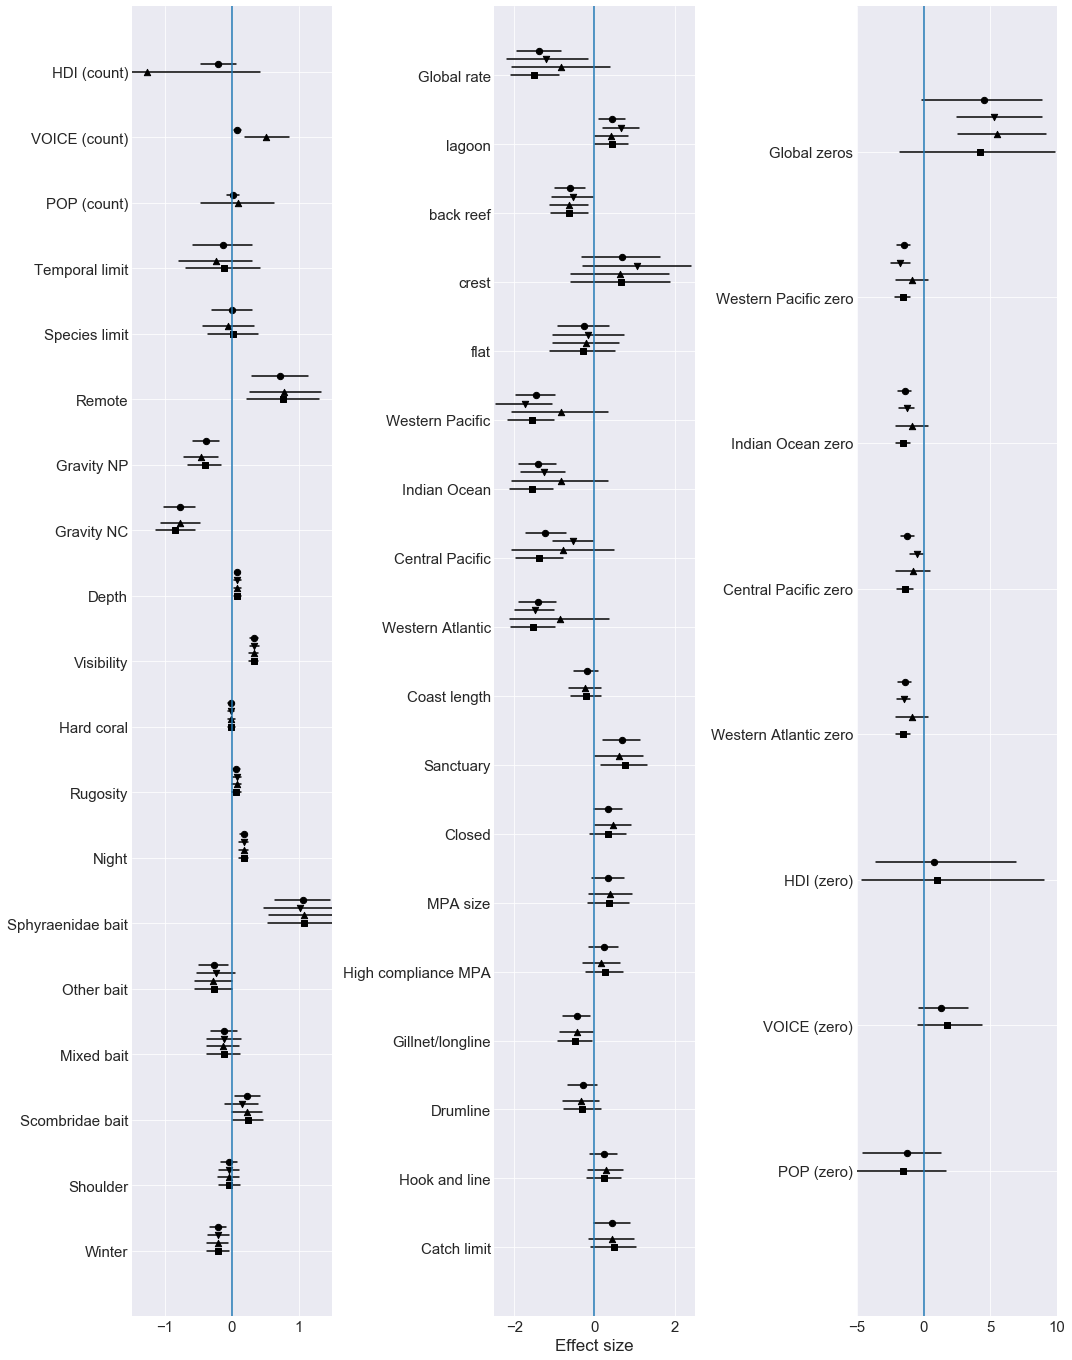

In [30]:
# Set up variables
varlist1 = ["Global_rate","Regional_rate","CoastLength","Sanctuary","Reef_type","Visibililty","Hard_coral","Rugosity"
            ,"Depth","Bait_type","Seasonality"][::-1]
varlist2 = ["Gravity_NP","Gravity_NC","Catch","Temporal","Species","Closed","High_compliance","MPA_size","Remote",
            "Gillnet_longline", "Drumline", "HookLine"][::-1]
varlist2b = ["HDI","VOICE","POP"]
varlist3 = ["Global_zeros","Regional_zeros","HDI","VOICE","POP"][::-1]


# Set up plot
fig = plt.figure(figsize=(15, 19))
gs = mp.gridspec.GridSpec(1, 3)
ax = np.array([fig.add_subplot(gs[i,j]) for i in range(1) for j in range(3)]).reshape(1,3)[0]
# Offset
oset = 0.12
# Point size
sx = 40

# Variable list 1
ax[0].plot(1,1,marker="")
ax[0].set_ylim(0,20)
ax[0].set_xlim(-1.5,1.5)

# Axis labels
alab = []

# Seasonality
tmp_f = BTrez_SH_full[grep('Seasonality',BTrez_SH_full.columns.values)]
tmp_c = BTrez_SH_count[grep('Seasonality',BTrez_SH_count.columns.values)]
tmp_n = BTrez_SH_null[grep('Seasonality',BTrez_SH_null.columns.values)]
ax[0].scatter(np.median(tmp_f,axis=0),[1,2],s=sx,c='black',marker='s')
ax[0].scatter(np.median(tmp_c,axis=0),[1+oset,2+oset],s=sx,c='black',marker='^')
ax[0].scatter(np.median(tmp_n,axis=0),[1+oset*2,2+oset*2],s=sx,c='black',marker='v')
ax[0].scatter(np.median(beta_Seasonality,axis=0),[1+oset*3,2+oset*3],s=sx,c='black',marker='o')
ax[0].plot(np.quantile(tmp_f,(0.05,0.95),axis=0).T[0],[1,1],c='black')
ax[0].plot(np.quantile(tmp_f,(0.05,0.95),axis=0).T[1],[2,2],c='black')
ax[0].plot(np.quantile(tmp_c,(0.05,0.95),axis=0).T[0],[1+oset,1+oset],c='black')
ax[0].plot(np.quantile(tmp_c,(0.05,0.95),axis=0).T[1],[2+oset,2+oset],c='black')
ax[0].plot(np.quantile(tmp_n,(0.05,0.95),axis=0).T[0],[1+oset*2,1+oset*2],c='black')
ax[0].plot(np.quantile(tmp_n,(0.05,0.95),axis=0).T[1],[2+oset*2,2+oset*2],c='black')
ax[0].plot(np.quantile(beta_Seasonality,(0.05,0.95),axis=0).T[0],[1+oset*3,1+oset*3],c='black')
ax[0].plot(np.quantile(beta_Seasonality,(0.05,0.95),axis=0).T[1],[2+oset*3,2+oset*3],c='black')
alab += SEA[1:]

# Bait type
tmp_f = BTrez_SH_full[grep('Bait_type',BTrez_SH_full.columns.values)]
tmp_c = BTrez_SH_count[grep('Bait_type',BTrez_SH_count.columns.values)]
tmp_n = BTrez_SH_null[grep('Bait_type',BTrez_SH_null.columns.values)]
ax[0].scatter(np.median(tmp_f,axis=0),[3,4,5,6],s=sx,c='black',marker='s')
ax[0].scatter(np.median(tmp_c,axis=0),[3+oset,4+oset,5+oset,6+oset],s=sx,c='black',marker='^')
ax[0].scatter(np.median(tmp_n,axis=0),[3+oset*2,4+oset*2,5+oset*2,6+oset*2],s=sx,c='black',marker='v')
ax[0].scatter(np.median(beta_Bait_type,axis=0),[3+oset*3,4+oset*3,5+oset*3,6+oset*3],s=sx,c='black',marker='o')
ax[0].plot(np.quantile(tmp_f,(0.05,0.95),axis=0).T[0],[3,3],c='black')
ax[0].plot(np.quantile(tmp_f,(0.05,0.95),axis=0).T[1],[4,4],c='black')
ax[0].plot(np.quantile(tmp_f,(0.05,0.95),axis=0).T[2],[5,5],c='black')
ax[0].plot(np.quantile(tmp_f,(0.05,0.95),axis=0).T[3],[6,6],c='black')
ax[0].plot(np.quantile(tmp_c,(0.05,0.95),axis=0).T[0],[3+oset,3+oset],c='black')
ax[0].plot(np.quantile(tmp_c,(0.05,0.95),axis=0).T[1],[4+oset,4+oset],c='black')
ax[0].plot(np.quantile(tmp_c,(0.05,0.95),axis=0).T[2],[5+oset,5+oset],c='black')
ax[0].plot(np.quantile(tmp_c,(0.05,0.95),axis=0).T[3],[6+oset,6+oset],c='black')
ax[0].plot(np.quantile(tmp_n,(0.05,0.95),axis=0).T[0],[3+oset*2,3+oset*2],c='black')
ax[0].plot(np.quantile(tmp_n,(0.05,0.95),axis=0).T[1],[4+oset*2,4+oset*2],c='black')
ax[0].plot(np.quantile(tmp_n,(0.05,0.95),axis=0).T[2],[5+oset*2,5+oset*2],c='black')
ax[0].plot(np.quantile(tmp_n,(0.05,0.95),axis=0).T[3],[6+oset*2,6+oset*2],c='black')
ax[0].plot(np.quantile(beta_Bait_type,(0.05,0.95),axis=0).T[0],[3+oset*3,3+oset*3],c='black')
ax[0].plot(np.quantile(beta_Bait_type,(0.05,0.95),axis=0).T[1],[4+oset*3,4+oset*3],c='black')
ax[0].plot(np.quantile(beta_Bait_type,(0.05,0.95),axis=0).T[2],[5+oset*3,5+oset*3],c='black')
ax[0].plot(np.quantile(beta_Bait_type,(0.05,0.95),axis=0).T[3],[6+oset*3,6+oset*3],c='black')
alab += [b+' bait' for b in BAIT[1:]]

# Time of day
tmp_f = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('TimeODay')]].values
tmp_c = BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('TimeODay')]].values
tmp_n = BTrez_SH_null[BTrez_SH_null.columns[list(BTrez_SH_null.columns.values).index('TimeODay')]].values
beta_TimeODay = tmp_f*loo_f+tmp_c*loo_c+tmp_n*loo_n
ax[0].scatter(np.median(tmp_f),7,s=sx,c='black',marker='s')
ax[0].scatter(np.median(tmp_c),7+oset,s=sx,c='black',marker='^')
ax[0].scatter(np.median(tmp_n),7+oset*2,s=sx,c='black',marker='v')
ax[0].scatter(np.median(beta_TimeODay),7+oset*3,s=sx,c='black',marker='o')
ax[0].plot(np.quantile(tmp_f,(0.05,0.95)),[7,7],c='black')
ax[0].plot(np.quantile(tmp_c,(0.05,0.95)),[7+oset,7+oset],c='black')
ax[0].plot(np.quantile(tmp_n,(0.05,0.95)),[7+oset*2,7+oset*2],c='black')
ax[0].plot(np.quantile(beta_TimeODay,(0.05,0.95)),[7+oset*3,7+oset*3],c='black')
alab += ['Night']

# Rugosity
tmp_f = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Rugosity')]].values
tmp_c = BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('Rugosity')]].values
tmp_n = BTrez_SH_null[BTrez_SH_null.columns[list(BTrez_SH_null.columns.values).index('Rugosity')]].values
ax[0].scatter(np.median(tmp_f),8,s=sx,c='black',marker='s')
ax[0].scatter(np.median(tmp_c),8+oset,s=sx,c='black',marker='^')
ax[0].scatter(np.median(tmp_n),8+oset*2,s=sx,c='black',marker='v')
ax[0].scatter(np.median(beta_rug),8+oset*3,s=sx,c='black',marker='o')
ax[0].plot(np.quantile(tmp_f,(0.05,0.95)),[8,8],c='black')
ax[0].plot(np.quantile(tmp_c,(0.05,0.95)),[8+oset,8+oset],c='black')
ax[0].plot(np.quantile(tmp_n,(0.05,0.95)),[8+oset*2,8+oset*2],c='black')
ax[0].plot(np.quantile(beta_rug,(0.05,0.95)),[8+oset*3,8+oset*3],c='black')
alab += ['Rugosity']

# Hard coral
i=9
tmp_f = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Hard_coral')]].values
tmp_c = BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('Hard_coral')]].values
tmp_n = BTrez_SH_null[BTrez_SH_null.columns[list(BTrez_SH_null.columns.values).index('Hard_coral')]].values
ax[0].scatter(np.median(tmp_f),i,s=sx,c='black',marker='s')
ax[0].scatter(np.median(tmp_c),i+oset,s=sx,c='black',marker='^')
ax[0].scatter(np.median(tmp_n),i+oset*2,s=sx,c='black',marker='v')
ax[0].scatter(np.median(beta_hc),i+oset*3,s=sx,c='black',marker='o')
ax[0].plot(np.quantile(tmp_f,(0.05,0.95)),[i,i],c='black')
ax[0].plot(np.quantile(tmp_c,(0.05,0.95)),[i+oset,i+oset],c='black')
ax[0].plot(np.quantile(tmp_n,(0.05,0.95)),[i+oset*2,i+oset*2],c='black')
ax[0].plot(np.quantile(beta_hc,(0.05,0.95)),[i+oset*3,i+oset*3],c='black')
alab += ['Hard coral']

# Visibility
i=10
tmp_f = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Visibililty')]].values
tmp_c = BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('Visibililty')]].values
tmp_n = BTrez_SH_null[BTrez_SH_null.columns[list(BTrez_SH_null.columns.values).index('Visibililty')]].values
ax[0].scatter(np.median(tmp_f),i,s=sx,c='black',marker='s')
ax[0].scatter(np.median(tmp_c),i+oset,s=sx,c='black',marker='^')
ax[0].scatter(np.median(tmp_n),i+oset*2,s=sx,c='black',marker='v')
ax[0].scatter(np.median(beta_vis),i+oset*3,s=sx,c='black',marker='o')
ax[0].plot(np.quantile(tmp_f,(0.05,0.95)),[i,i],c='black')
ax[0].plot(np.quantile(tmp_c,(0.05,0.95)),[i+oset,i+oset],c='black')
ax[0].plot(np.quantile(tmp_n,(0.05,0.95)),[i+oset*2,i+oset*2],c='black')
ax[0].plot(np.quantile(beta_vis,(0.05,0.95)),[i+oset*3,i+oset*3],c='black')
alab += ['Visibility']

# Depth
i=11
tmp_f = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Depth')]].values
tmp_c = BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('Depth')]].values
tmp_n = BTrez_SH_null[BTrez_SH_null.columns[list(BTrez_SH_null.columns.values).index('Depth')]].values
ax[0].scatter(np.median(tmp_f),i,s=sx,c='black',marker='s')
ax[0].scatter(np.median(tmp_c),i+oset,s=sx,c='black',marker='^')
ax[0].scatter(np.median(tmp_n),i+oset*2,s=sx,c='black',marker='v')
ax[0].scatter(np.median(beta_Depth),i+oset*3,s=sx,c='black',marker='o')
ax[0].plot(np.quantile(tmp_f,(0.05,0.95)),[i,i],c='black')
ax[0].plot(np.quantile(tmp_c,(0.05,0.95)),[i+oset,i+oset],c='black')
ax[0].plot(np.quantile(tmp_n,(0.05,0.95)),[i+oset*2,i+oset*2],c='black')
ax[0].plot(np.quantile(beta_Depth,(0.05,0.95)),[i+oset*3,i+oset*3],c='black')
alab += ['Depth']

# Gravity_NC
i=12
tmp_f = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Gravity_NC')]].values
tmp_c = BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('Gravity_NC')]].values
ax[0].scatter(np.median(tmp_f),i,s=sx,c='black',marker='s')
ax[0].scatter(np.median(tmp_c),i+oset,s=sx,c='black',marker='^')
ax[0].scatter(np.median(beta_Gravity_NC),i+oset*3,s=sx,c='black',marker='o')
ax[0].plot(np.quantile(tmp_f,(0.05,0.95)),[i,i],c='black')
ax[0].plot(np.quantile(tmp_c,(0.05,0.95)),[i+oset,i+oset],c='black')
ax[0].plot(np.quantile(beta_Gravity_NC,(0.05,0.95)),[i+oset*3,i+oset*3],c='black')
alab += ['Gravity NC']

# Gravity_NP
i=13
tmp_f = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Gravity_NP')]].values
tmp_c = BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('Gravity_NP')]].values
ax[0].scatter(np.median(tmp_f),i,s=sx,c='black',marker='s')
ax[0].scatter(np.median(tmp_c),i+oset,s=sx,c='black',marker='^')
ax[0].scatter(np.median(beta_Gravity_NP),i+oset*3,s=sx,c='black',marker='o')
ax[0].plot(np.quantile(tmp_f,(0.05,0.95)),[i,i],c='black')
ax[0].plot(np.quantile(tmp_c,(0.05,0.95)),[i+oset,i+oset],c='black')
ax[0].plot(np.quantile(beta_Gravity_NP,(0.05,0.95)),[i+oset*3,i+oset*3],c='black')
alab += ['Gravity NP']

# Remote
i=14
tmp_f = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Remote')]].values
tmp_c = BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('Remote')]].values
ax[0].scatter(np.median(tmp_f),i,s=sx,c='black',marker='s')
ax[0].scatter(np.median(tmp_c),i+oset,s=sx,c='black',marker='^')
ax[0].scatter(np.median(beta_Remote),i+oset*3,s=sx,c='black',marker='o')
ax[0].plot(np.quantile(tmp_f,(0.05,0.95)),[i,i],c='black')
ax[0].plot(np.quantile(tmp_c,(0.05,0.95)),[i+oset,i+oset],c='black')
ax[0].plot(np.quantile(beta_Remote,(0.05,0.95)),[i+oset*3,i+oset*3],c='black')
alab += ['Remote']

# Species
i=15
tmp_f = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Species')]].values
tmp_c = BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('Species')]].values
ax[0].scatter(np.median(tmp_f),i,s=sx,c='black',marker='s')
ax[0].scatter(np.median(tmp_c),i+oset,s=sx,c='black',marker='^')
ax[0].scatter(np.median(beta_Spp),i+oset*3,s=sx,c='black',marker='o')
ax[0].plot(np.quantile(tmp_f,(0.05,0.95)),[i,i],c='black')
ax[0].plot(np.quantile(tmp_c,(0.05,0.95)),[i+oset,i+oset],c='black')
ax[0].plot(np.quantile(beta_Spp,(0.05,0.95)),[i+oset*3,i+oset*3],c='black')
alab += ['Species limit']


# Temporal
i=16
tmp_f = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Temporal')]].values
tmp_c = BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('Temporal')]].values
ax[0].scatter(np.median(tmp_f),i,s=sx,c='black',marker='s')
ax[0].scatter(np.median(tmp_c),i+oset,s=sx,c='black',marker='^')
ax[0].scatter(np.median(beta_Temporal),i+oset*3,s=sx,c='black',marker='o')
ax[0].plot(np.quantile(tmp_f,(0.05,0.95)),[i,i],c='black')
ax[0].plot(np.quantile(tmp_c,(0.05,0.95)),[i+oset,i+oset],c='black')
ax[0].plot(np.quantile(beta_Temporal,(0.05,0.95)),[i+oset*3,i+oset*3],c='black')
alab += ['Temporal limit']

# Population
i=17
tmp_c = BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('POP')]].values
ax[0].scatter(np.median(tmp_c),i,s=sx,c='black',marker='^')
ax[0].scatter(np.median(tmp_c*loo_c),i+oset,s=sx,c='black',marker='o')
ax[0].plot(np.quantile(tmp_c,(0.05,0.95)),[i,i],c='black')
ax[0].plot(np.quantile(tmp_c*loo_c,(0.05,0.95)),[i+oset,i+oset],c='black')
alab += ['POP (count)']


# Voice
i=18
tmp_c = BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('VOICE')]].values
ax[0].scatter(np.median(tmp_c),i,s=sx,c='black',marker='^')
ax[0].scatter(np.median(tmp_c*loo_c),i+oset,s=sx,c='black',marker='o')
ax[0].plot(np.quantile(tmp_c,(0.05,0.95)),[i,i],c='black')
ax[0].plot(np.quantile(tmp_c*loo_c,(0.05,0.95)),[i+oset,i+oset],c='black')
alab += ['VOICE (count)']

# HDI
i=19
tmp_c = BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('HDI')]].values
ax[0].scatter(np.median(tmp_c),i,s=sx,c='black',marker='^')
ax[0].scatter(np.median(tmp_c*loo_c),i+oset,s=sx,c='black',marker='o')
ax[0].plot(np.quantile(tmp_c,(0.05,0.95)),[i,i],c='black')
ax[0].plot(np.quantile(tmp_c*loo_c,(0.05,0.95)),[i+oset,i+oset],c='black')
alab += ['HDI (count)']


ax[0].set_yticks(np.arange(len(alab))+1)
ax[0].set_yticklabels(alab,fontsize=15)

# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = #


# Variable list 1
ax[1].plot(1,1,marker="")
ax[1].set_ylim(0,19)
ax[1].set_xlim(-2.5,2.5)

# Axis labels
alab = []

# Catch
i=1
tmp_f = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Catch')]].values
tmp_c = BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('Catch')]].values
ax[1].scatter(np.median(tmp_f),i,s=sx,c='black',marker='s')
ax[1].scatter(np.median(tmp_c),i+oset,s=sx,c='black',marker='^')
ax[1].scatter(np.median(beta_Catch),i+oset*3,s=sx,c='black',marker='o')
ax[1].plot(np.quantile(tmp_f,(0.05,0.95)),[i,i],c='black')
ax[1].plot(np.quantile(tmp_c,(0.05,0.95)),[i+oset,i+oset],c='black')
ax[1].plot(np.quantile(beta_Catch,(0.05,0.95)),[i+oset*3,i+oset*3],c='black')
alab += ['Catch limit']

# HookLine
i=2
tmp_f = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('HookLine')]].values
tmp_c = BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('HookLine')]].values
ax[1].scatter(np.median(tmp_f),i,s=sx,c='black',marker='s')
ax[1].scatter(np.median(tmp_c),i+oset,s=sx,c='black',marker='^')
ax[1].scatter(np.median(beta_HookLine),i+oset*3,s=sx,c='black',marker='o')
ax[1].plot(np.quantile(tmp_f,(0.05,0.95)),[i,i],c='black')
ax[1].plot(np.quantile(tmp_c,(0.05,0.95)),[i+oset,i+oset],c='black')
ax[1].plot(np.quantile(beta_HookLine,(0.05,0.95)),[i+oset*3,i+oset*3],c='black')
alab += ['Hook and line']

# Drumline
i=3
tmp_f = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Drumline')]].values
tmp_c = BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('Drumline')]].values
ax[1].scatter(np.median(tmp_f),i,s=sx,c='black',marker='s')
ax[1].scatter(np.median(tmp_c),i+oset,s=sx,c='black',marker='^')
ax[1].scatter(np.median(beta_Drumline),i+oset*3,s=sx,c='black',marker='o')
ax[1].plot(np.quantile(tmp_f,(0.05,0.95)),[i,i],c='black')
ax[1].plot(np.quantile(tmp_c,(0.05,0.95)),[i+oset,i+oset],c='black')
ax[1].plot(np.quantile(beta_Drumline,(0.05,0.95)),[i+oset*3,i+oset*3],c='black')
alab += ['Drumline']

# Drumline
i=4
tmp_f = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Gillnet_longline')]].values
tmp_c = BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('Gillnet_longline')]].values
ax[1].scatter(np.median(tmp_f),i,s=sx,c='black',marker='s')
ax[1].scatter(np.median(tmp_c),i+oset,s=sx,c='black',marker='^')
ax[1].scatter(np.median(beta_Gill),i+oset*3,s=sx,c='black',marker='o')
ax[1].plot(np.quantile(tmp_f,(0.05,0.95)),[i,i],c='black')
ax[1].plot(np.quantile(tmp_c,(0.05,0.95)),[i+oset,i+oset],c='black')
ax[1].plot(np.quantile(beta_Gill,(0.05,0.95)),[i+oset*3,i+oset*3],c='black')
alab += ['Gillnet/longline']


# High_compliance
i=5
tmp_f = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('High_compliance')]].values
tmp_c = BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('High_compliance')]].values
ax[1].scatter(np.median(tmp_f),i,s=sx,c='black',marker='s')
ax[1].scatter(np.median(tmp_c),i+oset,s=sx,c='black',marker='^')
ax[1].scatter(np.median(beta_HIC),i+oset*3,s=sx,c='black',marker='o')
ax[1].plot(np.quantile(tmp_f,(0.05,0.95)),[i,i],c='black')
ax[1].plot(np.quantile(tmp_c,(0.05,0.95)),[i+oset,i+oset],c='black')
ax[1].plot(np.quantile(beta_HIC,(0.05,0.95)),[i+oset*3,i+oset*3],c='black')
alab += ['High compliance MPA']


# MPA_size
i=6
tmp_f = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('MPA_size')]].values
tmp_c = BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('MPA_size')]].values
ax[1].scatter(np.median(tmp_f),i,s=sx,c='black',marker='s')
ax[1].scatter(np.median(tmp_c),i+oset,s=sx,c='black',marker='^')
ax[1].scatter(np.median(beta_MPAsize),i+oset*3,s=sx,c='black',marker='o')
ax[1].plot(np.quantile(tmp_f,(0.05,0.95)),[i,i],c='black')
ax[1].plot(np.quantile(tmp_c,(0.05,0.95)),[i+oset,i+oset],c='black')
ax[1].plot(np.quantile(beta_MPAsize,(0.05,0.95)),[i+oset*3,i+oset*3],c='black')
alab += ['MPA size']

# Closed
i=7
tmp_f = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Closed')]].values
tmp_c = BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('Closed')]].values
ax[1].scatter(np.median(tmp_f),i,s=sx,c='black',marker='s')
ax[1].scatter(np.median(tmp_c),i+oset,s=sx,c='black',marker='^')
ax[1].scatter(np.median(beta_clo),i+oset*3,s=sx,c='black',marker='o')
ax[1].plot(np.quantile(tmp_f,(0.05,0.95)),[i,i],c='black')
ax[1].plot(np.quantile(tmp_c,(0.05,0.95)),[i+oset,i+oset],c='black')
ax[1].plot(np.quantile(beta_clo,(0.05,0.95)),[i+oset*3,i+oset*3],c='black')
alab += ['Closed']

# Sanctuary
i=8
tmp_f = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Sanctuary')]].values
tmp_c = BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('Sanctuary')]].values
ax[1].scatter(np.median(tmp_f),i,s=sx,c='black',marker='s')
ax[1].scatter(np.median(tmp_c),i+oset,s=sx,c='black',marker='^')
ax[1].scatter(np.median(beta_Sanctuary),i+oset*3,s=sx,c='black',marker='o')
ax[1].plot(np.quantile(tmp_f,(0.05,0.95)),[i,i],c='black')
ax[1].plot(np.quantile(tmp_c,(0.05,0.95)),[i+oset,i+oset],c='black')
ax[1].plot(np.quantile(beta_Sanctuary,(0.05,0.95)),[i+oset*3,i+oset*3],c='black')
alab += ['Sanctuary']


# CoastLength
i=9
tmp_f = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('CoastLength')]].values
tmp_c = BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('CoastLength')]].values
ax[1].scatter(np.median(tmp_f),i,s=sx,c='black',marker='s')
ax[1].scatter(np.median(tmp_c),i+oset,s=sx,c='black',marker='^')
ax[1].scatter(np.median(beta_CoastL),i+oset*3,s=sx,c='black',marker='o')
ax[1].plot(np.quantile(tmp_f,(0.05,0.95)),[i,i],c='black')
ax[1].plot(np.quantile(tmp_c,(0.05,0.95)),[i+oset,i+oset],c='black')
ax[1].plot(np.quantile(beta_CoastL,(0.05,0.95)),[i+oset*3,i+oset*3],c='black')
alab += ['Coast length']


# Regional rate
tmp_f = BTrez_SH_full[grep('Regional_rate',BTrez_SH_full.columns.values)]
tmp_c = BTrez_SH_count[grep('Regional_rate',BTrez_SH_count.columns.values)]
tmp_n = BTrez_SH_null[grep('Regional_rate',BTrez_SH_null.columns.values)]
ax[1].scatter(np.median(tmp_f,axis=0),[10,11,12,13],s=sx,c='black',marker='s')
ax[1].scatter(np.median(tmp_c,axis=0),[10+oset,11+oset,12+oset,13+oset],s=sx,c='black',marker='^')
ax[1].scatter(np.median(tmp_n,axis=0),[10+oset*2,11+oset*2,12+oset*2,13+oset*2],s=sx,c='black',marker='v')
ax[1].scatter(np.median(beta_Region,axis=0),[10+oset*3,11+oset*3,12+oset*3,13+oset*3],s=sx,c='black',marker='o')
ax[1].plot(np.quantile(tmp_f,(0.05,0.95),axis=0).T[0],[10,10],c='black')
ax[1].plot(np.quantile(tmp_f,(0.05,0.95),axis=0).T[1],[11,11],c='black')
ax[1].plot(np.quantile(tmp_f,(0.05,0.95),axis=0).T[2],[12,12],c='black')
ax[1].plot(np.quantile(tmp_f,(0.05,0.95),axis=0).T[3],[13,13],c='black')
ax[1].plot(np.quantile(tmp_c,(0.05,0.95),axis=0).T[0],[10+oset,10+oset],c='black')
ax[1].plot(np.quantile(tmp_c,(0.05,0.95),axis=0).T[1],[11+oset,11+oset],c='black')
ax[1].plot(np.quantile(tmp_c,(0.05,0.95),axis=0).T[2],[12+oset,12+oset],c='black')
ax[1].plot(np.quantile(tmp_c,(0.05,0.95),axis=0).T[3],[13+oset,13+oset],c='black')
ax[1].plot(np.quantile(tmp_n,(0.05,0.95),axis=0).T[0],[10+oset*2,10+oset*2],c='black')
ax[1].plot(np.quantile(tmp_n,(0.05,0.95),axis=0).T[1],[11+oset*2,11+oset*2],c='black')
ax[1].plot(np.quantile(tmp_n,(0.05,0.95),axis=0).T[2],[12+oset*2,12+oset*2],c='black')
ax[1].plot(np.quantile(tmp_n,(0.05,0.95),axis=0).T[3],[13+oset*2,13+oset*2],c='black')
ax[1].plot(np.quantile(beta_Region,(0.05,0.95),axis=0).T[0],[10+oset*3,10+oset*3],c='black')
ax[1].plot(np.quantile(beta_Region,(0.05,0.95),axis=0).T[1],[11+oset*3,11+oset*3],c='black')
ax[1].plot(np.quantile(beta_Region,(0.05,0.95),axis=0).T[2],[12+oset*3,12+oset*3],c='black')
ax[1].plot(np.quantile(beta_Region,(0.05,0.95),axis=0).T[3],[13+oset*3,13+oset*3],c='black')
alab += Region


# Reef type
tmp_f = BTrez_SH_full[grep('Reef_type',BTrez_SH_full.columns.values)]
tmp_c = BTrez_SH_count[grep('Reef_type',BTrez_SH_count.columns.values)]
tmp_n = BTrez_SH_null[grep('Reef_type',BTrez_SH_null.columns.values)]
ax[1].scatter(np.median(tmp_f,axis=0),[14,15,16,17],s=sx,c='black',marker='s')
ax[1].scatter(np.median(tmp_c,axis=0),[14+oset,15+oset,16+oset,17+oset],s=sx,c='black',marker='^')
ax[1].scatter(np.median(tmp_n,axis=0),[14+oset*2,15+oset*2,16+oset*2,17+oset*2],s=sx,c='black',marker='v')
ax[1].scatter(np.median(beta_Reef_type,axis=0),[14+oset*3,15+oset*3,16+oset*3,17+oset*3],s=sx,c='black',marker='o')
ax[1].plot(np.quantile(tmp_f,(0.05,0.95),axis=0).T[0],[14,14],c='black')
ax[1].plot(np.quantile(tmp_f,(0.05,0.95),axis=0).T[1],[15,15],c='black')
ax[1].plot(np.quantile(tmp_f,(0.05,0.95),axis=0).T[2],[16,16],c='black')
ax[1].plot(np.quantile(tmp_f,(0.05,0.95),axis=0).T[3],[17,17],c='black')
ax[1].plot(np.quantile(tmp_c,(0.05,0.95),axis=0).T[0],[14+oset,14+oset],c='black')
ax[1].plot(np.quantile(tmp_c,(0.05,0.95),axis=0).T[1],[15+oset,15+oset],c='black')
ax[1].plot(np.quantile(tmp_c,(0.05,0.95),axis=0).T[2],[16+oset,16+oset],c='black')
ax[1].plot(np.quantile(tmp_c,(0.05,0.95),axis=0).T[3],[17+oset,17+oset],c='black')
ax[1].plot(np.quantile(tmp_n,(0.05,0.95),axis=0).T[0],[14+oset*2,14+oset*2],c='black')
ax[1].plot(np.quantile(tmp_n,(0.05,0.95),axis=0).T[1],[15+oset*2,15+oset*2],c='black')
ax[1].plot(np.quantile(tmp_n,(0.05,0.95),axis=0).T[2],[16+oset*2,16+oset*2],c='black')
ax[1].plot(np.quantile(tmp_n,(0.05,0.95),axis=0).T[3],[17+oset*2,17+oset*2],c='black')
ax[1].plot(np.quantile(beta_Reef_type,(0.05,0.95),axis=0).T[0],[14+oset*3,14+oset*3],c='black')
ax[1].plot(np.quantile(beta_Reef_type,(0.05,0.95),axis=0).T[1],[15+oset*3,15+oset*3],c='black')
ax[1].plot(np.quantile(beta_Reef_type,(0.05,0.95),axis=0).T[2],[16+oset*3,16+oset*3],c='black')
ax[1].plot(np.quantile(beta_Reef_type,(0.05,0.95),axis=0).T[3],[17+oset*3,17+oset*3],c='black')
alab += RTY[1:]


# Global rate
i=18
tmp_f = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Global_rate')]].values
tmp_c = BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('Global_rate')]].values
tmp_n = BTrez_SH_null[BTrez_SH_null.columns[list(BTrez_SH_null.columns.values).index('Global_rate')]].values
ax[1].scatter(np.median(tmp_f),i,s=sx,c='black',marker='s')
ax[1].scatter(np.median(tmp_c),i+oset,s=sx,c='black',marker='^')
ax[1].scatter(np.median(tmp_n),i+oset*2,s=sx,c='black',marker='v')
ax[1].scatter(np.median(beta_global),i+oset*3,s=sx,c='black',marker='o')
ax[1].plot(np.quantile(tmp_f,(0.05,0.95)),[i,i],c='black')
ax[1].plot(np.quantile(tmp_c,(0.05,0.95)),[i+oset,i+oset],c='black')
ax[1].plot(np.quantile(tmp_n,(0.05,0.95)),[i+oset*2,i+oset*2],c='black')
ax[1].plot(np.quantile(beta_global,(0.05,0.95)),[i+oset*3,i+oset*3],c='black')
alab += ['Global rate']



ax[1].set_yticks(np.arange(len(alab))+1)
ax[1].set_yticklabels(alab,fontsize=15)

# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = #


# Variable list 1
ax[2].plot(1,1,marker="")
ax[2].set_ylim(0,9)
ax[2].set_xlim(-5,10)

# Axis labels
alab = []


# Population
i=1
tmp_f = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('POP')]].values
#tmp_c = BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('POP')]].values
ax[2].scatter(np.median(tmp_f),i,s=sx,c='black',marker='s')
#ax[2].scatter(np.median(tmp_c),i+oset,s=sx,c='black',marker='^')
ax[2].scatter(np.median(beta_POP),i+oset,s=sx,c='black',marker='o')
ax[2].plot(np.quantile(tmp_f,(0.05,0.95)),[i,i],c='black')
#ax[2].plot(np.quantile(tmp_c,(0.05,0.95)),[i+oset,i+oset],c='black')
ax[2].plot(np.quantile(beta_POP,(0.05,0.95)),[i+oset,i+oset],c='black')
alab += ['POP (zero)']


# Voice
i=2
tmp_f = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('VOICE')]].values
#tmp_c = BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('POP')]].values
ax[2].scatter(np.median(tmp_f),i,s=sx,c='black',marker='s')
#ax[2].scatter(np.median(tmp_c),i+oset,s=sx,c='black',marker='^')
ax[2].scatter(np.median(beta_VOICE),i+oset,s=sx,c='black',marker='o')
ax[2].plot(np.quantile(tmp_f,(0.05,0.95)),[i,i],c='black')
#ax[2].plot(np.quantile(tmp_c,(0.05,0.95)),[i+oset,i+oset],c='black')
ax[2].plot(np.quantile(beta_VOICE,(0.05,0.95)),[i+oset,i+oset],c='black')
alab += ['VOICE (zero)']

# HDI
i=3
tmp_f = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('HDI')]].values
#tmp_c = BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('POP')]].values
ax[2].scatter(np.median(tmp_f),i,s=sx,c='black',marker='s')
#ax[2].scatter(np.median(tmp_c),i+oset,s=sx,c='black',marker='^')
ax[2].scatter(np.median(beta_HDI),i+oset,s=sx,c='black',marker='o')
ax[2].plot(np.quantile(tmp_f,(0.05,0.95)),[i,i],c='black')
#ax[2].plot(np.quantile(tmp_c,(0.05,0.95)),[i+oset,i+oset],c='black')
ax[2].plot(np.quantile(beta_HDI,(0.05,0.95)),[i+oset,i+oset],c='black')
alab += ['HDI (zero)']


# Regional rate
tmp_f = BTrez_SH_full[grep('Regional_rate',BTrez_SH_full.columns.values)]
tmp_c = BTrez_SH_count[grep('Regional_rate',BTrez_SH_count.columns.values)]
tmp_n = BTrez_SH_null[grep('Regional_rate',BTrez_SH_null.columns.values)]
ax[2].scatter(np.median(tmp_f,axis=0),[4,5,6,7],s=sx,c='black',marker='s')
ax[2].scatter(np.median(tmp_c,axis=0),[4+oset,5+oset,6+oset,7+oset],s=sx,c='black',marker='^')
ax[2].scatter(np.median(tmp_n,axis=0),[4+oset*2,5+oset*2,6+oset*2,7+oset*2],s=sx,c='black',marker='v')
ax[2].scatter(np.median(beta_Region,axis=0),[4+oset*3,5+oset*3,6+oset*3,7+oset*3],s=sx,c='black',marker='o')
ax[2].plot(np.quantile(tmp_f,(0.05,0.95),axis=0).T[0],[4,4],c='black')
ax[2].plot(np.quantile(tmp_f,(0.05,0.95),axis=0).T[1],[5,5],c='black')
ax[2].plot(np.quantile(tmp_f,(0.05,0.95),axis=0).T[2],[6,6],c='black')
ax[2].plot(np.quantile(tmp_f,(0.05,0.95),axis=0).T[3],[7,7],c='black')
ax[2].plot(np.quantile(tmp_c,(0.05,0.95),axis=0).T[0],[4+oset,4+oset],c='black')
ax[2].plot(np.quantile(tmp_c,(0.05,0.95),axis=0).T[1],[5+oset,5+oset],c='black')
ax[2].plot(np.quantile(tmp_c,(0.05,0.95),axis=0).T[2],[6+oset,6+oset],c='black')
ax[2].plot(np.quantile(tmp_c,(0.05,0.95),axis=0).T[3],[7+oset,7+oset],c='black')
ax[2].plot(np.quantile(tmp_n,(0.05,0.95),axis=0).T[0],[4+oset*2,4+oset*2],c='black')
ax[2].plot(np.quantile(tmp_n,(0.05,0.95),axis=0).T[1],[5+oset*2,5+oset*2],c='black')
ax[2].plot(np.quantile(tmp_n,(0.05,0.95),axis=0).T[2],[6+oset*2,6+oset*2],c='black')
ax[2].plot(np.quantile(tmp_n,(0.05,0.95),axis=0).T[3],[7+oset*2,7+oset*2],c='black')
ax[2].plot(np.quantile(beta_Region,(0.05,0.95),axis=0).T[0],[4+oset*3,4+oset*3],c='black')
ax[2].plot(np.quantile(beta_Region,(0.05,0.95),axis=0).T[1],[5+oset*3,5+oset*3],c='black')
ax[2].plot(np.quantile(beta_Region,(0.05,0.95),axis=0).T[2],[6+oset*3,6+oset*3],c='black')
ax[2].plot(np.quantile(beta_Region,(0.05,0.95),axis=0).T[3],[7+oset*3,7+oset*3],c='black')
alab += [r+' zero' for r in Region]


# Global rate
i=8
tmp_f = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Global_zeros')]].values
tmp_c = BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('Global_zeros')]].values
tmp_n = BTrez_SH_null[BTrez_SH_null.columns[list(BTrez_SH_null.columns.values).index('Global_zeros')]].values
beta_global_zeros = tmp_f*loo_f+tmp_c*loo_c+tmp_n*loo_n
ax[2].scatter(np.median(tmp_f),i,s=sx,c='black',marker='s')
ax[2].scatter(np.median(tmp_c),i+oset,s=sx,c='black',marker='^')
ax[2].scatter(np.median(tmp_n),i+oset*2,s=sx,c='black',marker='v')
ax[2].scatter(np.median(beta_global_zeros),i+oset*3,s=sx,c='black',marker='o')
ax[2].plot(np.quantile(tmp_f,(0.05,0.95)),[i,i],c='black')
ax[2].plot(np.quantile(tmp_c,(0.05,0.95)),[i+oset,i+oset],c='black')
ax[2].plot(np.quantile(tmp_n,(0.05,0.95)),[i+oset*2,i+oset*2],c='black')
ax[2].plot(np.quantile(beta_global_zeros,(0.05,0.95)),[i+oset*3,i+oset*3],c='black')
alab += ['Global zeros']


ax[2].set_yticks(np.arange(len(alab))+1)
ax[2].set_yticklabels(alab,fontsize=15)


ax[0].axvline(x=0)
ax[1].axvline(x=0)
ax[2].axvline(x=0)

ax[0].tick_params(labelsize=15)
ax[1].tick_params(labelsize=15)
ax[2].tick_params(labelsize=15)

#ax[0].text(-2,17,"a",fontsize=20, fontweight='bold')
#ax[1].text(-3.5,19,"b",fontsize=20, fontweight='bold')
#ax[2].text(-7,9,"c",fontsize=20, fontweight='bold')

ax[1].set_xlabel('Effect size',fontsize=17)

plt.tight_layout()
plt.savefig('ED_Figure_2.pdf');

In [31]:
np.median(tmp_f)

4.251520678441041

In [32]:
np.quantile(tmp_f,(0.05,0.95),axis=0)[0]

-1.7460548775151903

In [33]:
np.quantile(BTrez_SH_full.alpha.values, (.5,0.05,.95))

array([6.64100932, 5.79329259, 7.73185966])

In [34]:
np.quantile(beta_HDI, (.5,0.05,.95))

array([ 0.77230329, -3.532652  ,  6.93255233])

In [35]:
np.quantile(beta_Seasonality.Winter, (.5,0.05,.95))

array([-0.20579332, -0.33196081, -0.0801237 ])

In [36]:
np.quantile(beta_Seasonality.Shoulder, (.5,0.05,.95))

array([-0.03805662, -0.15937755,  0.08177681])

In [37]:
np.quantile(beta_vis, (.5,0.05,.95))

array([0.32922159, 0.27125855, 0.38582939])

In [38]:
np.quantile(beta_hc, (.5,0.05,.95))

array([-0.00916413, -0.05168873,  0.03260526])

In [39]:
np.quantile(beta_rug, (.5,0.05,.95))

array([0.06921172, 0.01677374, 0.12176136])

In [40]:
np.quantile(beta_Depth, (.5,0.05,.95))

array([0.08379726, 0.04296387, 0.12531662])

In [41]:
BAIT

['Clupeidae', 'Scombridae', 'Mixed', 'Other', 'Sphyraenidae']

In [42]:
[np.quantile(beta_Bait_type[b], (.5,0.05,.95)) for b in beta_Bait_type.columns]

[array([0.23372913, 0.05007312, 0.41768479]),
 array([-0.12267891, -0.31528565,  0.07201671]),
 array([-0.27287048, -0.48813896, -0.05090302]),
 array([1.07139241, 0.65319053, 1.46827268])]

## Expected benefits

In [43]:
# Gillnet/longline ban
1-np.percentile(np.exp(beta_global)/np.exp(beta_global-beta_Gill),(5,50,95))

array([0.54034088, 0.35984749, 0.10969006])

In [44]:
# Catch limit
1-np.percentile(np.exp(beta_global)/np.exp(beta_global+beta_Catch),(5,50,95))

array([ 0.58433083,  0.35966982, -0.00310277])

In [45]:
# Average closure
1-np.percentile(np.exp(beta_global)/np.exp(beta_global+beta_clo),(5,50,95))

array([ 0.49694546,  0.28103383, -0.00889556])

In [46]:
# Big closure
1-np.percentile(np.exp(beta_global)/np.exp(beta_global+beta_clo+beta_MPAsize),(5,50,95))

array([0.70800599, 0.48566947, 0.11641382])

In [47]:
# Shark Sanctuary
1-np.percentile(np.exp(beta_global)/np.exp(beta_global+beta_Sanctuary),(5,50,95))

array([0.67858796, 0.49549366, 0.20124448])

In [48]:
# Drumline ban
1-np.percentile(np.exp(beta_global)/np.exp(beta_global-beta_Drumline),(5,50,95))

array([ 0.47928301,  0.25091059, -0.0789777 ])

In [49]:
# Hook and line
1-np.percentile(np.exp(beta_global)/np.exp(beta_global+beta_HookLine),(5,50,95))

array([ 0.43431655,  0.20369099, -0.12292138])

## Parameter plots

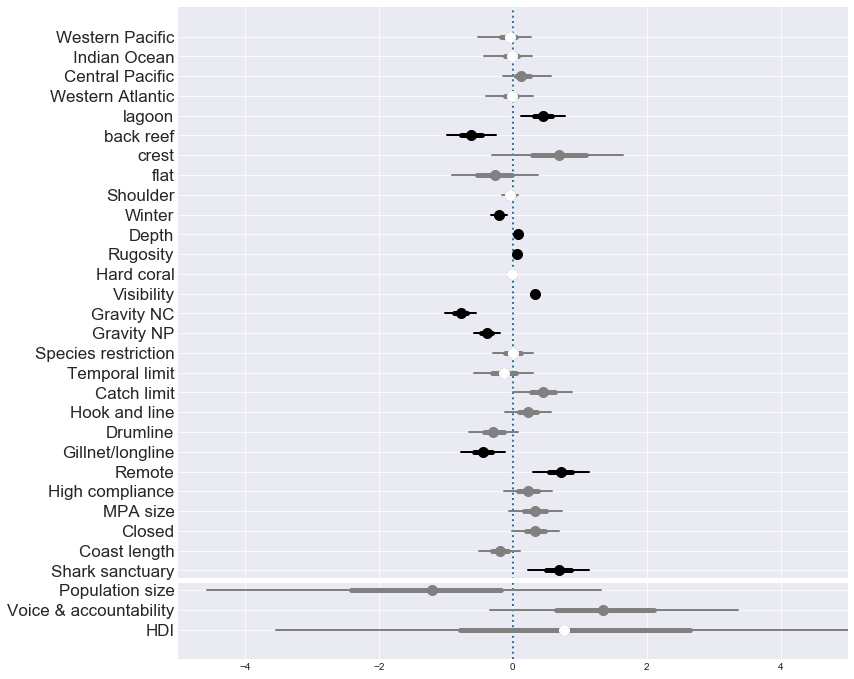

In [50]:
fig = plt.figure(figsize=(12, 12))
gs = mp.gridspec.GridSpec(1, nfg)
ax_ = [fig.add_subplot(gs[0,i]) for i in range(nfg)]

xadj = 5

for i in range(nfg):
    ax = ax_[i]
    ax.axvline(x=0, linestyle=':', linewidth=2)
    [gelplot(ax,params[i][j],j,csize=20,lwd50=5,lwd95=2) for j in range(nparms)]
    if i==0:
        ax.set_yticks(range(nparms))
        ax.set_yticklabels(parmlabels,fontsize=17)
    else:
        ax.set_yticklabels('')
    ax.set_xlim(-xadj,xadj)
    ax.set_ylabel('')
    #Aax.set_title(BTlabs[i],fontsize=17)

ax.axhline(2.5,c='white',linewidth=5)



plt.savefig('ED_Figure_1.pdf')

In [51]:
paramz = [beta_HDI, beta_VOICE, beta_POP, beta_Gravity_NP, beta_Gravity_NC]
parmlabelz = ['HDI','Voice & accountability','Population size','Gravity (Nearest population)','Gravity (Nearest city)']
nparamz = len(paramz)

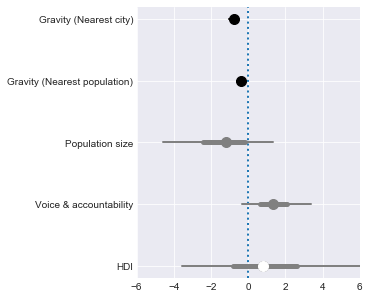

In [52]:
fig = plt.figure(figsize=(4, 5))
gs = mp.gridspec.GridSpec(1, nfg)
ax_ = [fig.add_subplot(gs[0,i]) for i in range(nfg)]

xadj = 6

for i in range(1):
    ax = ax_[i]
    ax.axvline(x=0, linestyle=':', linewidth=2)
    [gelplot(ax,paramz[j],j,csize=20,lwd50=5,lwd95=2) for j in range(nparamz)]
    if i==0:
        ax.set_yticks(range(nparamz))
        ax.set_yticklabels(parmlabelz)
    else:
        ax.set_yticklabels('')
    ax.set_xlim(-xadj,xadj)
    ax.set_ylabel('')
    
plt.savefig('Figure_1d.pdf', bbox_inches='tight')

In [53]:
beta_zero = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Global_zeros')]].values*loo_f+BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('Global_zeros')]].values*loo_c+BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Global_zeros')]].values*loo_n

In [54]:
pz = 1-np.mean(invlogit(beta_zero))
pz,pz*len(MaxN)

(0.09770720062329907, 1481.7296974523304)

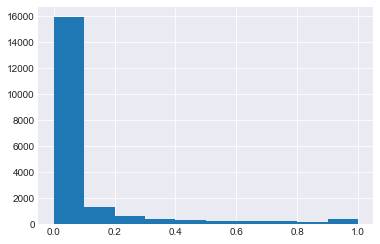

In [55]:
plt.hist(1-invlogit(beta_zero));

In [56]:
1.02e+04

10200.0

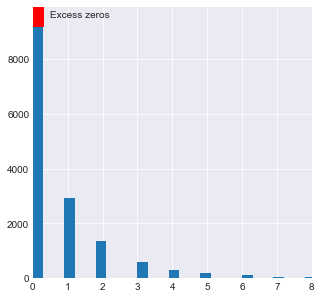

In [57]:
fig = plt.figure(figsize=(5,5))
plt.hist(xdata.MaxN_shark.values,bins=100)
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((0.01, 1.02e+04*(1-pz)), .27, 1.02e+04*pz, alpha=1, color='red'))
plt.text(0.5, 1.0e+04*(1-pz/2), 'Excess zeros')
plt.xlim(0,8)
plt.savefig('Figure_1b.pdf')

## Cohen's d calcs

In [58]:
varlist = ['Sanctuary','Gillnet_longline', 'Drumline', 'HookLine', 'Closed', 'MPA_size', 'High_compliance', 'Catch', 'Temporal', 'Species']
varnames = ['Shark sanctuary','Gillnet/longline', 'Drumline', 'Hook & Line', 'Closed area', 'MPA size', 'High compliance', 'Catch limit', 'Temporal limit', 'Species limit']
nvar = len(varlist)
BTrez = BTrez_SH_full[varlist]*loo_f+BTrez_SH_count[varlist]*loo_c
Cohens_d = BTrez_SH_full[varlist]*(np.sqrt(3)/np.pi)*loo_f+BTrez_SH_count[varlist]*(np.sqrt(3)/np.pi)*loo_c
Cohens_d.columns = varnames

In [59]:
Cohens_d.head()

,Shark sanctuary,Gillnet/longline,Drumline,Hook & Line,Closed area,MPA size,High compliance,Catch limit,Temporal limit,Species limit
0,0.418861,-0.265506,-0.146740,-0.029704,0.136080,0.272427,-0.015956,0.324450,-0.083351,0.075366
1,0.366369,-0.371641,0.023703,0.045578,0.101821,0.034210,0.299604,0.201966,0.006210,-0.001045
2,0.385028,-0.288856,-0.165756,0.235910,0.115470,0.024489,0.296026,0.400590,0.182105,-0.082682
3,0.360814,-0.265842,0.123419,0.018835,0.242317,0.247623,0.052878,0.185023,-0.149541,-0.090635
4,0.307517,-0.229331,-0.155166,0.099831,0.045795,0.377781,0.159681,0.232214,-0.046643,0.051247


In [60]:
dfx = Cohens_d.melt(value_name='Posterior')
dfx.head()

,variable,Posterior
0,Shark sanctuary,0.418861
1,Shark sanctuary,0.366369
2,Shark sanctuary,0.385028
3,Shark sanctuary,0.360814
4,Shark sanctuary,0.307517


In [61]:
# Aesthetics 

# Colour palette for variables
#varpal = sns.cubehelix_palette(nvar, rot=-.25, light=.7)
varpal = palettable.wesanderson.Zissou_5.hex_colors+palettable.wesanderson.Aquatic1_5.hex_colors+palettable.wesanderson.Aquatic2_5.hex_colors+palettable.wesanderson.Aquatic3_5.hex_colors

/Users/aaronmacneil/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:848: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout()


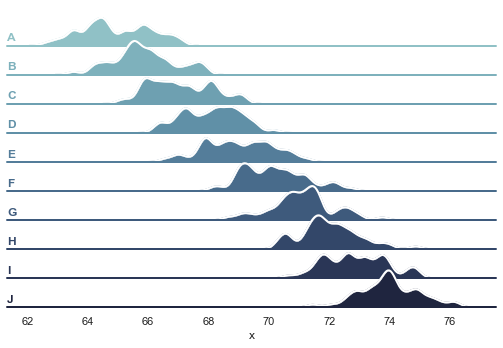

In [62]:

sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data
rs = np.random.RandomState(1979)
x = rs.randn(500)
g = np.tile(list("ABCDEFGHIJ"), 50)
df = pd.DataFrame(dict(x=x, g=g))
m = df.g.map(ord)
df["x"] += m

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "x", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "x")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

<Figure size 504x864 with 0 Axes>

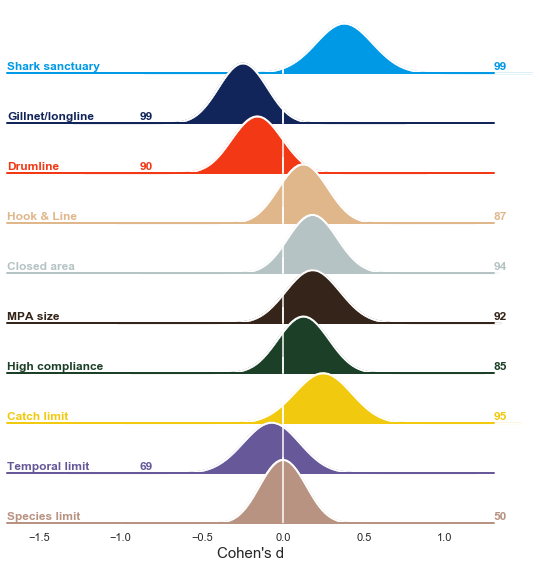

In [63]:
# Joy Division plot

fig = plt.figure(figsize=(7, 12))


# Initialize the FacetGrid object
g = sns.FacetGrid(dfx, row="variable", hue="variable", aspect=10, height=.8, palette=varpal)

# Draw the densities in a few steps
knl = 'epa'
g.map(sns.kdeplot, "Posterior", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2, kernel=knl)
g.map(sns.kdeplot, "Posterior", clip_on=False, color="w", lw=2, bw=.2, kernel=knl)
g.map(plt.axhline, y=0, lw=2, clip_on=False)


lim = 1.7
yloc = 0.1
xos = 0.4

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, yloc, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)
    ax.set_xlim(-lim,lim-xos)
    
# Define and use a simple function to label the plot in axes coordinates
def pd_label(x, color, label):
    ax = plt.gca()
    if np.median(x)<0:
        ax.text(0.3, yloc, str(int(np.round(100*(sum(x<0)/len(x)),0))), fontweight="bold", color=color,
                ha="right", va="center", transform=ax.transAxes)
    else:
        ax.text(1, yloc, str(int(np.round(100*(sum(x>0)/len(x)),0))), fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)
    ax.set_xlim(-lim,lim-xos)

g.map(label, "Posterior")
g.map(pd_label, "Posterior")


# Add line at zero
g.map(plt.axvline, x=0, color='w', linestyle='-')

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)
plt.xlabel("Cohen's d", fontsize=15)
plt.savefig('Figure_2b.pdf', bbox_inches='tight');

In [64]:
def PPplot(intercept,slope, covariate,label,bins=(90,80,70,60,50),ax=None, colx='black',ymax=4):
    x = np.linspace(min(covariate), max(covariate))
    for b in bins:
        # Plot shaded uncertainty regions
        lower = np.exp(np.percentile(intercept,50-b/2)+np.percentile(slope,50-b/2)*x)
        upper = np.exp(np.percentile(intercept,50+b/2)+np.percentile(slope,50+b/2)*x)
        ax.fill_between(x, lower, upper, where=upper>lower, facecolor=colx,alpha=0.1)
    y = np.exp(np.median(intercept)+np.median(slope)*x)
    ax.plot(x,y,colx,linewidth=3)
    ax.set_title(label)
    ax.set_ylim(0,ymax)

In [65]:
# Observed data for x-var plotting
pltdata = [(0,1),(0,1),(0,1),(-1,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1)]

In [66]:
varlist

['Sanctuary',
 'Gillnet_longline',
 'Drumline',
 'HookLine',
 'Closed',
 'MPA_size',
 'High_compliance',
 'Catch',
 'Temporal',
 'Species']

In [67]:
xlabs = [('Absent','Present'),('Absent','Present'),('Absent','Present'),('Absent','Present'),('Absent','Present'),('Min','Max'),('No','Yes'),('Absent','Present'),('Absent','Present'),('Absent','Present')]

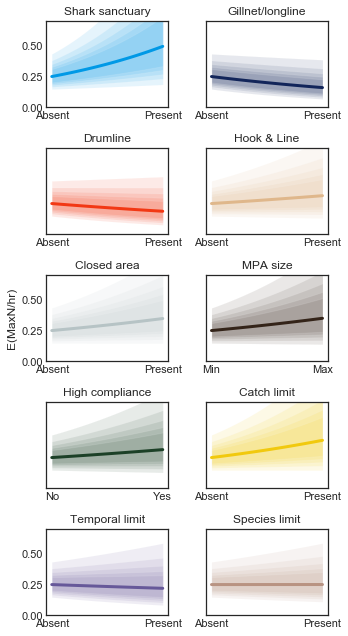

In [68]:
fig = plt.figure(figsize=(5, 9))
gs = mp.gridspec.GridSpec(5, 2)
ax_ = np.array([fig.add_subplot(gs[i,j]) for i in range(5) for j in range(2)]).reshape(1,10)[0]

xadj = 5

grx = beta_global

for i in range(nvar):
    PPplot(grx,BTrez[varlist[i]],(0,1),varnames[i],colx=varpal[i],ax=ax_[i],ymax=.7)
    ax_[i].tick_params(axis=u'both', which=u'both',length=0)
    ax_[i].set_xticks((0,1))
    ax_[i].set_xticklabels(xlabs[i],rotation=0,ha='center')
    #if i==5:
        #ax_[i].set_ylabel('Expected MaxN change')

# Adjust labelling
[plt.setp(ax_[i].get_yticklabels(), visible=False) for i in (1,2,3,5,6,7,9)]


#plt.setp(ax_[7].get_xticklabels(), visible=False)

ax_[4].set_ylabel('E(MaxN/hr)')

plt.tight_layout()
plt.savefig('Figure_2a.pdf', bbox_inches='tight');

In [69]:
BTrez_SH_null.columns


Index(['Unnamed: 0', 'Global_rate', 'pi_t__0', 'pi_t__1', 'pi_t__2', 'pi_t__3',
       'η0_USA-Western Atlantic', 'η0_Bahamas', 'η0_Australia-Pacific',
       'η0_Australia IOT',
       ...
       'Regional_rate_Western Pacific', 'σ0_η', 'σ0_κ', 'σ0_υ_z',
       'Regional_zeros__0', 'Regional_zeros__1', 'Regional_zeros__2',
       'Regional_zeros__3', 'σ0_η_z', 'alpha'],
      dtype='object', length=156)

In [70]:
beta_Region.columns

Index(['Western Atlantic', 'Central Pacific', 'Indian Ocean',
       'Western Pacific'],
      dtype='object')

In [71]:
np.exp(np.quantile(beta_Region,(.5,.05,.95),axis=0))

array([[0.24263817, 0.29250859, 0.24228068, 0.23212652],
       [0.15218264, 0.17986621, 0.1525682 , 0.1419343 ],
       [0.38724911, 0.48783715, 0.37958504, 0.37663993]])

In [72]:
# Full + count model intercept weights
loo_f2 = (loo_f/(loo_c+loo_f))
loo_c2 = (loo_c/(loo_c+loo_f))
BG = BTrez_SH_full[BTrez_SH_full.columns[list(BTrez_SH_full.columns.values).index('Global_rate')]].values*loo_f2+BTrez_SH_count[BTrez_SH_count.columns[list(BTrez_SH_count.columns.values).index('Global_rate')]].values*loo_c2

In [73]:
# Regional rates
#"""
#"""
#"""
beta_Region_ex = np.exp(beta_Region)
beta_global_ex = np.exp(BG)
#"""


In [74]:
# Regional null rates
#"""
beta_Region_null = BTrez_SH_null[grep('Regional_rate',BTrez_SH_null.columns.values)]
beta_Region_null.columns = [x[14:] for x in beta_Region_null.columns]
beta_global_null = BTrez_SH_null.Global_rate

#"""
#"""
beta_Region_null_ex = np.exp(BTrez_SH_null[grep('Regional_rate',BTrez_SH_null.columns.values)])
beta_Region_null_ex.columns = [x[14:] for x in beta_Region_null_ex.columns]
beta_global_null_ex = np.exp(BTrez_SH_null.Global_rate)
#"""


In [75]:
np.exp(np.quantile(beta_Region_null,(.5,.05,.95),axis=0))

array([[0.22896571, 0.59258157, 0.28741924, 0.17820909],
       [0.13752837, 0.35655603, 0.160935  , 0.08690092],
       [0.36720434, 0.97069469, 0.48492033, 0.35013199]])

In [76]:
# Difference from global intercept
Net_null_shark = beta_Region_null.sub(beta_global_null.squeeze(),axis=0).dropna()
Net_shark = beta_Region.sub(BG.squeeze(),axis=0).dropna()

In [77]:
Net_null_shark.columns.values

array(['Western Atlantic', 'Central Pacific', 'Indian Ocean',
       'Western Pacific'], dtype=object)

In [78]:
valx = Net_null_shark.columns.values
colx = ['turquoise','blue','xkcd:sienna','xkcd:burgundy']

/Users/aaronmacneil/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:323: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot(x, y, color=color, label=label, **kwargs)


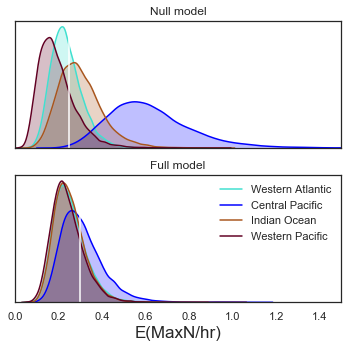

In [79]:
fig = plt.figure(figsize=(5,5))
gs = mp.gridspec.GridSpec(2, 1)
ax_ = np.array([fig.add_subplot(gs[i,j]) for i in range(2) for j in range(1)]).reshape(1,2)[0]

for i in range(len(valx)):
    sns.kdeplot(beta_Region_null_ex[valx[i]],shade=True,c=colx[i],ax=ax_[0],legend=False, gridsize=1000)
    sns.kdeplot(beta_Region_ex[valx[i]],shade=True,c=colx[i],ax=ax_[1], gridsize=1000)

ax_[0].set_title('Null model')
ax_[1].set_title('Full model') 
    
# Tidy plots
lim = 1.5
ax_[0].set_xlim(-0,lim)
ax_[0].axvline(np.median(beta_global_ex),linestyle="-",c="white")
ax_[1].set_xlim(-0,lim)
ax_[1].axvline(beta_global_null_ex.median(),linestyle="-",c="white")
ax_[1].set_xlabel('E(MaxN/hr)',fontsize=17)

plt.setp(ax_[0].get_yticklabels(), visible=False)
plt.setp(ax_[0].get_xticklabels(), visible=False)
plt.setp(ax_[1].get_yticklabels(), visible=False)
plt.tight_layout()
plt.savefig('Figure_1c.pdf', bbox_inches='tight');

In [80]:
# Observed positive records
OCC_reef = np.array([(np.sum(xdata.MaxN_shark.values[xdata.reef_id.values==R])>0)*1 for R in Reef])
# Observed averages
mu_reef = np.array([np.mean(xdata.MaxN_shark.values[xdata.reef_id.values==R]) for R in Reef])
# Probability of a shark
p_set = np.array([sum((xdata.MaxN_shark.values[xdata.reef_id.values==R]>0)*1)/len(xdata.MaxN_shark.values[xdata.reef_id.values==R]) for R in Reef])
p_reef = np.array([np.sum(p_set[Ilr==i]>0)/len(p_set[Ilr==i]) for i in range(nlocs)])

In [81]:
len(np.array(RegionL)[Irl])

58

In [82]:
# Proportion of reefs without sharks
1-sum(p_set>0)/len(p_set)

0.19407008086253374

In [83]:
pd.DataFrame({'Location':LocationR, 'Region':np.array(RegionL)[Irl], 'Nreefs':[len(p_set[Ilr==i]) for i in range(nlocs)],'Mean_P(no_sharks)':p_reef}).to_csv('Mean_ReefAbsence.csv',index=False)

In [84]:
# Number of replicate sets per reef
nreps_r = np.array([len(xdata.MaxN_shark.values[xdata.reef_id.values==R]) for R in Reef])
np.median(nreps_r)

39.0

In [85]:
np.mean(p_set[Ilr==LocationR.index('Australia-Pacific')])

0.7219218896732815

In [86]:
np.mean(p_set[Ilr==LocationR.index('French Polynesia')])

0.7903015083591798

In [87]:
rnam = np.array([xdata.reef_name.values[list(xdata.reef_id.values).index(r)] for r in Reef])

In [88]:
# Reef-scale lat/lon
SSlat = np.array([np.mean(xdata.set_latitude.values[xdata.reef_id.values==R]) for R in Reef])
SSlon = np.array([np.mean(xdata.set_longitude.values[xdata.reef_id.values==R]) for R in Reef])

In [89]:
mp.pyplot.style.use('seaborn-darkgrid')

In [90]:
# Symbols for each region type
regnam = np.array([xdata.region_name.values[list(xdata.reef_id.values).index(r)] for r in Reef])
Reg,Irg = indexall(regnam)

rsym = np.array(['^','o','s','D'])[Irg]

/Users/aaronmacneil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  after removing the cwd from sys.path.
/Users/aaronmacneil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


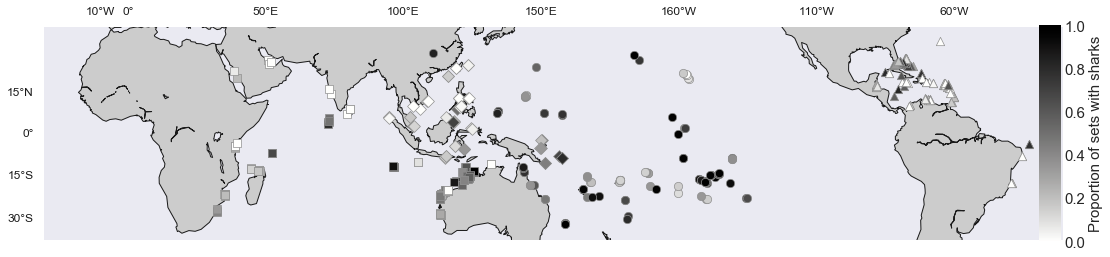

In [91]:
#"""
fig = plt.figure(figsize=(15, 5))
# Instantiate basemap
m = bm(llcrnrlon=-30,llcrnrlat=-37,urcrnrlon=340,urcrnrlat=37,projection='mill')
m.drawcoastlines()
#m.drawcountries()
m.fillcontinents()
m.drawparallels(np.arange(int(-30.1),int(30.1),15), labels=[1,0,1], linewidth=0.0)
m.drawmeridians(np.arange(int(0),int(360),50),labels=[1,0,1], linewidth=0.0)


# Convert longitude
SSlon[SSlon<0] = SSlon[SSlon<0]+360
xx,yy = m(SSlon,SSlat)
cmap = co.cm.gray_r
zz = np.array([cmap([p_set[i]]) for i in range(nreefs)])


# Plot points
[plt.scatter(x, y, c=z, edgecolor='#909090', linewidth=0.7, s=70, alpha=1, marker=m, zorder=5) for x,y,z,m in zip(xx,yy,zz,rsym)];


cax = fig.add_axes([0.966, 0.2, 0.02, 0.6])
norm = mp.colors.Normalize(vmin=min(mu_reef), vmax=max(mu_reef))
cb = mp.colorbar.ColorbarBase(cax, cmap, label='Proportion of sets with sharks')
cb.ax.tick_params(labelsize=15)
cb.set_label(label='Proportion of sets with sharks', size=15)

fig.tight_layout()
plt.savefig('Figure_1a.pdf', bbox_inches='tight');
#"""

In [92]:
lox = np.array([xdata.location_name.values[list(xdata.reef_id.values).index(r)] for r in Reef])

In [93]:
pd.DataFrame({'Location':lox,'Reef_ID':Reef, 'ReefName':rnam, 'Region':regnam, 'Lat':SSlat, 'Lon':SSlon}).to_csv('ReefCheck.csv',index=False)

In [94]:
xdata.columns

Index(['region_name', 'region_id', 'location_name', 'location_code',
       'location_id', 'site_name', 'site_code', 'site_id', 'reef_name',
       'reef_type', 'reef_code', 'reef_id', 'trip_year', 'trip_code', 'set_id',
       'set_code', 'set_date', 'set_latitude', 'set_longitude', 'maxn',
       'functional_group', 'depth', 'drop_time', 'haul_time', 'bait',
       'bait_oiled', 'current_flow_estimated', 'current_flow_instrumented',
       'visibility', 'field_of_view', 'substrate_relief_sd',
       'substrate_relief_mean', 'equipment_frame_type', 'equipment_camera',
       'equipment_stereo_camera', 'equipment_camera_height',
       'equipment_arm_length', 'ascidians', 'bleached_corals', 'bryozoa',
       'consolidated', 'crinoids', 'halimeda', 'hard_coral', 'hydrocoral',
       'hydroids', 'invertebrate_complex', 'macroalgae', 'mangrove',
       'seagrass', 'soft_coral', 'sponge', 'true_anemones', 'unconsolidated',
       'zoanthids', 'video_length_watched', 'video_filename', 'vide

# National comparison



Re-do these scores using observed null model (nussiance parameters only) and the addition of each  new management option -; explain this rationale in the conservation score methods!

In [95]:
# National rates
#"""
beta_nation = np.exp(BTrez_SH_full[grep('η0_',BTrez_SH_full.columns.values)]*loo_f2+BTrez_SH_count[grep('η0_',BTrez_SH_count.columns.values)]*loo_c2)
beta_nation.columns = [x[3:] for x in beta_nation.columns]
Bnation = beta_nation.median(axis=0)
BNx = Bnation.sub(np.exp(beta_Region).median(axis=0).values[Ig],axis=0)
#"""



In [96]:
beta_nation.mean(axis=0)

USA-Western Atlantic              0.430542
Bahamas                           0.387180
Australia-Pacific                 0.446686
Australia IOT                     0.243423
Maldives                          0.455422
Malaysia                          0.130621
Solomon Islands                   0.384041
Indonesia                         0.157802
Palau                             0.562727
American Samoa                    0.247169
New Caledonia                     0.690634
Belize                            0.268863
Jamaica                           0.241519
Trinidad and Tobago               0.393160
Vanuatu                           0.329458
British West Indies               0.271873
Fiji                              0.339991
Colombia                          0.132507
Australia-Indian Ocean            0.282359
South Africa                      0.313897
Mozambique                        0.239363
Niue                              0.543154
Japan                             0.155749
Seychelles 

In [97]:
# National rates
#"""
beta_nation_null = np.exp(BTrez_SH_null[grep('η0_',BTrez_SH_null.columns.values)])
beta_nation_null.columns = [x[3:] for x in beta_nation_null.columns]
Bnation_null = beta_nation_null.median(axis=0)
BNx_null = Bnation_null.sub(np.exp(beta_Region_null).median(axis=0).values[Ig],axis=0)
#"""


In [98]:
# Regional colors
colsx = np.array(colx)[Ig]

In [99]:
BTrez_SH_null.head()

,Unnamed: 0,Global_rate,pi_t__0,pi_t__1,pi_t__2,pi_t__3,η0_USA-Western Atlantic,η0_Bahamas,η0_Australia-Pacific,η0_Australia IOT,...,Regional_rate_Western Pacific,σ0_η,σ0_κ,σ0_υ_z,Regional_zeros__0,Regional_zeros__1,Regional_zeros__2,Regional_zeros__3,σ0_η_z,alpha
0,0,-1.583659,0.088167,0.621406,-0.180973,0.111352,-1.476539,-0.232598,0.338663,-0.253124,...,-1.410273,1.000561,1.072866,1.739983,8.527868,10.476610,6.465139,7.655935,7.668780,6.528335
1,1,-0.484740,-0.620667,0.108466,-0.680332,-0.217182,-1.240408,-0.340204,-0.066751,0.036098,...,-0.867132,1.036508,1.188762,1.475393,6.178200,7.440682,5.237715,6.249266,8.989780,7.465940
2,2,-0.906508,-0.639613,0.047206,-0.723437,-0.274638,-0.697273,-0.408274,-0.083422,0.016188,...,-1.132864,1.028088,1.194473,0.355435,7.015247,7.457838,6.977492,7.302841,7.864036,7.268930
3,3,-0.591007,-0.656047,0.019008,-0.629347,-0.905808,-0.766692,-0.754586,0.956137,-0.078553,...,-1.789338,1.052344,1.152056,1.911426,6.564672,5.572458,7.914495,6.033966,8.089471,6.245186
4,4,-0.624174,-1.398446,-0.597614,-0.967315,-1.148977,-1.451582,-0.328556,0.345725,-0.522018,...,-1.551866,1.102858,1.042604,0.227840,7.710936,7.857853,7.562839,7.767864,6.987470,6.589936


In [100]:
colnames = BTrez_SH_null.columns.values

In [101]:
# Regional expected value
REx = pd.DataFrame(BTrez_SH_null[colnames[np.array([list(colnames).index(x) for x in grep('Regional_rate',colnames)])]])
REx.columns = [x[14:] for x in REx.columns]
RMedian = REx.median()

# National expected value
ex_val = BTrez_SH_null[colnames[np.array([list(colnames).index(x) for x in grep('η0_',colnames)])]]
ex_val.columns = [x[3:] for x in ex_val.columns.values]
ex_val = ex_val[ex_val.mean().sort_values().index.values]
Elocation = ex_val.columns.values

In [102]:
# National presence
p_presence = invlogit(BTrez_SH_null[colnames[np.array([list(colnames).index(x) for x in grep('η0z',colnames)])]])
p_presence.columns = [x[4:] for x in p_presence.columns.values]
p_presence = p_presence[p_presence.mean().sort_values().index.values]
Plocation = p_presence.columns.values

In [103]:
# Key to match null model estimates to observed nation indexing
lindx = np.array([LocationR.index(x) for x in Elocation])
lindx

array([29, 17, 40, 54, 22, 50, 41,  7,  5, 35, 34, 28, 55, 56, 24, 53, 12,
       52, 47, 57, 49, 38, 48, 45, 26, 46, 15, 11, 20, 37, 42, 16, 31, 14,
        0, 32, 33,  9, 13, 39,  4,  6, 19, 23,  1,  3, 36, 51, 25, 43,  8,
       18, 21, 44, 27, 30,  2, 10])

In [104]:
# Regional index for new location order
zkey = pd.DataFrame({'Location':Elocation,'Region':np.array(Region)[Ig][lindx]})
zkey = zkey.set_index('Location')

In [105]:
# Get proportion of reefs with gillnets and longlines - use lindx to match order with those in results
zkey['propgill'] = np.array([sum(GILL[Ilr==lindx[i]])/len(GILL[Ilr==lindx[i]]) for i in range(nlocs)])
# Get proportion of reefs without closures
zkey['propclo'] = 1-np.array([sum(CLO[Ilr==lindx[i]])/len(CLO[Ilr==lindx[i]]) for i in range(nlocs)])
# Get proportion of reefs without shark sanctuary
zkey['propban'] = 1-SSA[lindx]
# Get proportion of reefs without Catch limits
zkey['propcat'] = 1-np.array([sum(BAG[Ilr==lindx[i]])/len(BAG[Ilr==lindx[i]]) for i in range(nlocs)])
# Get expected value from null model
zkey['ex_val'] = ex_val.median(axis=0)

In [106]:
zkey

,Region,propgill,propclo,propban,propcat,ex_val
Location,,,,,,
Philippines,Western Pacific,0.750000,0.750000,1,1.000000,-2.792398
Colombia,Western Atlantic,1.000000,1.000000,1,1.000000,-2.748751
Sri Lanka,Indian Ocean,0.666667,0.666667,1,1.000000,-2.628868
Dutch Antilles Leeward,Western Atlantic,0.545455,0.818182,1,1.000000,-2.416246
Japan,Western Pacific,0.000000,1.000000,1,1.000000,-2.343919
Guam,Central Pacific,0.000000,0.000000,1,1.000000,-2.275316
Tanzania,Indian Ocean,0.500000,1.000000,1,1.000000,-2.179404
Indonesia,Western Pacific,0.000000,0.933333,1,0.933333,-2.047618
Malaysia,Western Pacific,0.000000,0.250000,1,1.000000,-2.001638


In [107]:
# Get gillnet effect sizes per location
gilman = zkey.ex_val+zkey.propgill*(np.median(beta_Gill)*-1)

In [108]:
# Get large closure effect sizes per location
cloman = zkey.ex_val+zkey.propclo*np.median(beta_clo)+zkey.propclo*np.median(beta_MPAsize)

In [109]:
# Get average closure effect sizes per location
cloman2 = zkey.ex_val+zkey.propclo*np.median(beta_clo)

In [110]:
# Get shark sanctuary effect per location
banman = zkey.ex_val+zkey.propban*np.median(beta_Sanctuary)

In [111]:
# Get Catch limit effect per location
catman = zkey.ex_val+zkey.propcat*np.median(beta_Catch)

# Conservation potential

In [112]:
# Proportion of regional-scale posterior less than national expexcted values
Depletion = pd.DataFrame([sum(zkey.ex_val[c]>REx[zkey.Region[c]])/len(REx[zkey.Region[c]])*np.median(p_presence[c]) for c in Elocation]).T
Depletion.columns = Elocation
Depletion = Depletion[Depletion.median().sort_values().index.values]
Dlocs = Depletion.columns

In [113]:
len(Depletion.T.values[Depletion.T<0.5])/len(Depletion.T.values),sum((Depletion.T.values<0.5))

(0.5862068965517241, array([34]))

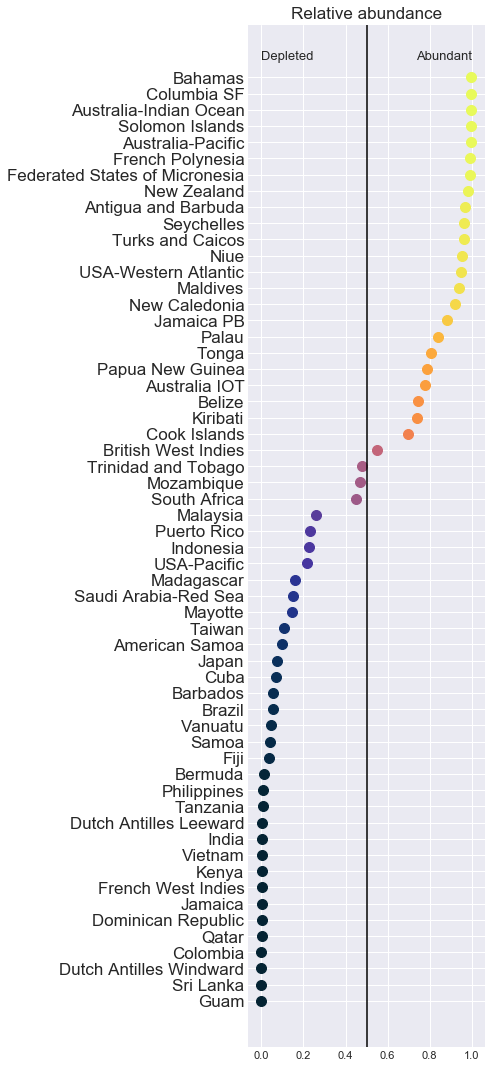

In [114]:
fig = plt.figure(figsize=(7, 15))
ax = fig.add_subplot(111)


#[ax.plot((Depletion[Dlocs[i]],Depletion_gill[Dlocs[i]]),(i,i),c='black',zorder=0) for i in range(nlocs)]

[ax.scatter(Depletion[Dlocs[i]],i,c=co.cm.thermal(Depletion[Dlocs[i]]),s=100) for i in range(nlocs)]
#[ax.scatter(Depletion_gill[Dlocs[i]],i,c=co.cm.thermal(Depletion_gill[Dlocs[i]]),edgecolor='black',s=100) for i in range(nlocs)]


ax.set_yticks(range(nlocs))
ax.set_yticklabels(Dlocs,fontsize=17)
plt.axvline(x=0.5, color='black', linestyle='-')
plt.text(0.,nlocs+0.1,'Depleted',fontsize=13)
plt.text(1.,nlocs+0.1,'Abundant',fontsize=13,horizontalalignment='right')
ax.set_xlabel('',fontsize=17)
ax.set_title('Relative abundance',fontsize=17)
fig.tight_layout()
plt.savefig('Figure_3x.pdf');

## Gillnet/longline potential

In [115]:
# National value scaled to region plus gillent potential
Depletion_gill = pd.DataFrame([sum(np.median(gilman[c])>REx[zkey.Region[c]])/len(REx[zkey.Region[c]])*np.median(p_presence[c]) for c in Elocation]).T
Depletion_gill.columns = Elocation
Depletion_gill = Depletion_gill[Dlocs.values]

In [116]:
imp_gill = Depletion_gill-Depletion
per_imp_gill = np.mean(imp_gill[imp_gill>0],axis=1)
per_imp_gill

0    0.086458
dtype: float64

In [117]:
np.mean(imp_gill,axis=1)

0    0.055154
dtype: float64

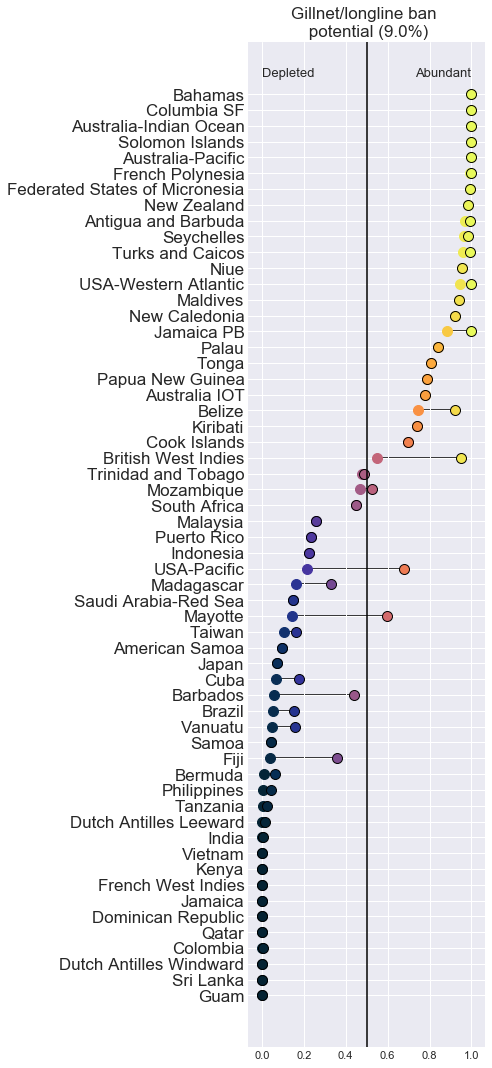

In [118]:
fig = plt.figure(figsize=(7, 15))
ax = fig.add_subplot(111)


[ax.plot((Depletion[Dlocs[i]],Depletion_gill[Dlocs[i]]),(i,i),c='black',zorder=0) for i in range(nlocs)]

[ax.scatter(Depletion[Dlocs[i]],i,c=co.cm.thermal(Depletion[Dlocs[i]]),s=100) for i in range(nlocs)]
[ax.scatter(Depletion_gill[Dlocs[i]],i,c=co.cm.thermal(Depletion_gill[Dlocs[i]]),edgecolor='black',s=100) for i in range(nlocs)]


ax.set_yticks(range(nlocs))
ax.set_yticklabels(Dlocs,fontsize=17)
plt.axvline(x=0.5, color='black', linestyle='-')
plt.text(0.,nlocs+0.1,'Depleted',fontsize=13)
plt.text(1.,nlocs+0.1,'Abundant',fontsize=13,horizontalalignment='right')
ax.set_xlabel('',fontsize=17)
ax.set_title('Gillnet/longline ban \n potential ('+ str(np.round(per_imp_gill[0]*100,0)) +'%)',fontsize=17)
fig.tight_layout()
plt.savefig('Figure_3b.pdf');

In [119]:
# National value scaled to region plus closure potential
Depletion_clo2 = pd.DataFrame([sum(np.median(cloman2[c])>REx[zkey.Region[c]])/len(REx[zkey.Region[c]])*np.median(p_presence[c]) for c in Elocation]).T

Depletion_clo2.columns = Elocation
Depletion_clo2 = Depletion_clo2[Dlocs.values]

In [120]:
imp_clo2 = Depletion_clo2-Depletion
per_imp_clo2 = np.mean(imp_clo2[imp_clo2>0],axis=1)
per_imp_clo2

0    0.081245
dtype: float64

## Big closure potential

In [121]:
# National value scaled to region plus closure potential
Depletion_clo = pd.DataFrame([sum(np.median(cloman[c])>REx[zkey.Region[c]])/len(REx[zkey.Region[c]])*np.median(p_presence[c]) for c in Elocation]).T

Depletion_clo.columns = Elocation
Depletion_clo = Depletion_clo[Dlocs.values]

In [122]:
imp_clo = Depletion_clo-Depletion
per_imp_clo = np.mean(imp_clo[imp_clo>0],axis=1)
per_imp_clo

0    0.173167
dtype: float64

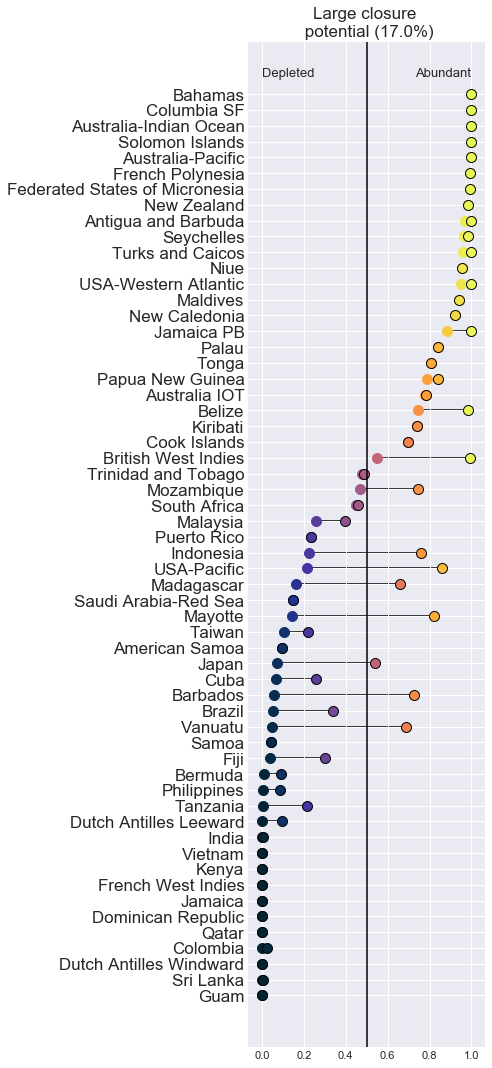

In [123]:
fig = plt.figure(figsize=(7, 15))
ax = fig.add_subplot(111)


[ax.plot((Depletion[Dlocs[i]],Depletion_clo[Dlocs[i]]),(i,i),c='black',zorder=0) for i in range(nlocs)]

[ax.scatter(Depletion[Dlocs[i]],i,c=co.cm.thermal(Depletion[Dlocs[i]]),s=100) for i in range(nlocs)]
[ax.scatter(Depletion_clo[Dlocs[i]],i,c=co.cm.thermal(Depletion_clo[Dlocs[i]]),edgecolor='black',s=100) for i in range(nlocs)]


ax.set_yticks(range(nlocs))
ax.set_yticklabels(Dlocs,fontsize=17)
plt.axvline(x=0.5, color='black', linestyle='-')
plt.text(0.,nlocs+0.1,'Depleted',fontsize=13)
plt.text(1.,nlocs+0.1,'Abundant',fontsize=13,horizontalalignment='right')
ax.set_xlabel('',fontsize=17)
ax.set_title('Large closure \n potential ('+ str(np.round(per_imp_clo[0]*100,0)) +'%)',fontsize=17)
fig.tight_layout()
plt.savefig('Figure_3c.pdf');

## Catch limit potential

In [124]:
# National value scaled to region plus closure potential
Depletion_cat = pd.DataFrame([sum(np.median(catman[c])>REx[zkey.Region[c]])/len(REx[zkey.Region[c]])*np.median(p_presence[c]) for c in Location]).T

Depletion_cat.columns = Location
Depletion_cat = Depletion_cat[Dlocs.values]

In [125]:
imp_cat = Depletion_cat-Depletion
per_imp_cat = np.mean(imp_cat[imp_cat>0],axis=1)
per_imp_cat

0    0.145095
dtype: float64

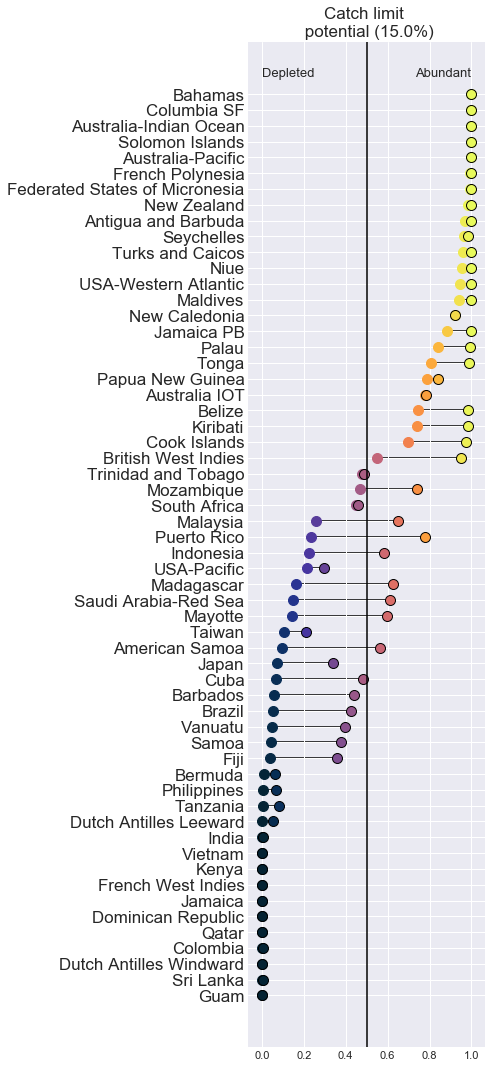

In [126]:
fig = plt.figure(figsize=(7, 15))
ax = fig.add_subplot(111)


[ax.plot((Depletion[Dlocs[i]],Depletion_cat[Dlocs[i]]),(i,i),c='black',zorder=0) for i in range(nlocs)]

[ax.scatter(Depletion[Dlocs[i]],i,c=co.cm.thermal(Depletion[Dlocs[i]]),s=100) for i in range(nlocs)]
[ax.scatter(Depletion_cat[Dlocs[i]],i,c=co.cm.thermal(Depletion_cat[Dlocs[i]]),edgecolor='black',s=100) for i in range(nlocs)]


ax.set_yticks(range(nlocs))
ax.set_yticklabels(Dlocs,fontsize=17)
plt.axvline(x=0.5, color='black', linestyle='-')
plt.text(0.,nlocs+0.1,'Depleted',fontsize=13)
plt.text(1.,nlocs+0.1,'Abundant',fontsize=13,horizontalalignment='right')
ax.set_xlabel('',fontsize=17)
ax.set_title('Catch limit \n potential ('+ str(np.round(per_imp_cat[0]*100,0)) +'%)',fontsize=17)
fig.tight_layout()
plt.savefig('Figure_3d.pdf');

## Shark Sanctuary potential

In [127]:
# National value scaled to region plus closure potential
Depletion_ban = pd.DataFrame([sum(np.median(banman[c])>REx[zkey.Region[c]])/len(REx[zkey.Region[c]])*np.median(p_presence[c]) for c in Location]).T

Depletion_ban.columns = Location
Depletion_ban = Depletion_ban[Dlocs.values]

In [128]:
imp_ban = Depletion_ban-Depletion
per_imp_ban = np.mean(imp_ban[imp_ban>0],axis=1)
per_imp_ban

0    0.253063
dtype: float64

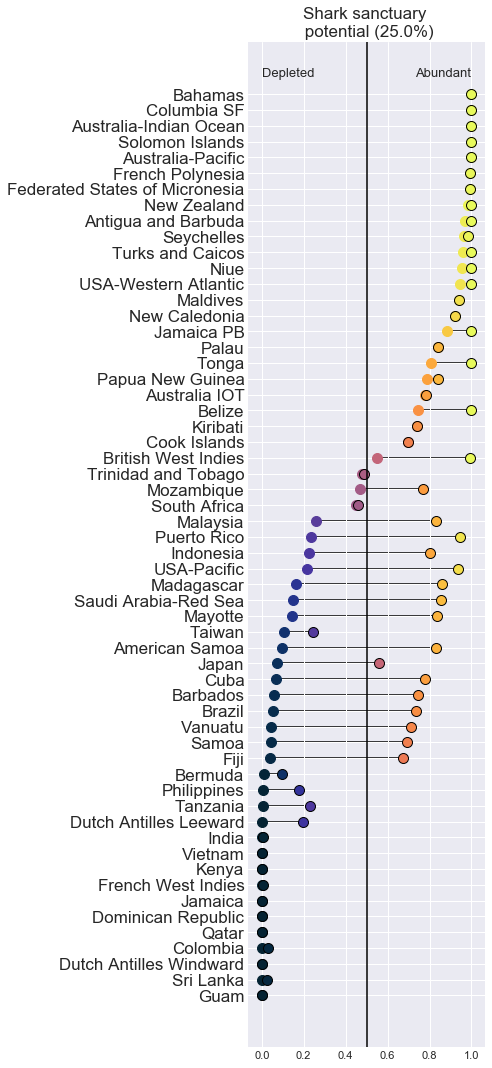

In [129]:
fig = plt.figure(figsize=(7, 15))
ax = fig.add_subplot(111)


[ax.plot((Depletion[Dlocs[i]],Depletion_ban[Dlocs[i]]),(i,i),c='black',zorder=0) for i in range(nlocs)]

[ax.scatter(Depletion[Dlocs[i]],i,c=co.cm.thermal(Depletion[Dlocs[i]]),s=100) for i in range(nlocs)]
[ax.scatter(Depletion_ban[Dlocs[i]],i,c=co.cm.thermal(Depletion_ban[Dlocs[i]]),edgecolor='black',s=100) for i in range(nlocs)]


ax.set_yticks(range(nlocs))
ax.set_yticklabels(Dlocs,fontsize=17)
plt.axvline(x=0.5, color='black', linestyle='-')
plt.text(0.,nlocs+0.1,'Depleted',fontsize=13)
plt.text(1.,nlocs+0.1,'Abundant',fontsize=13,horizontalalignment='right')
ax.set_xlabel('',fontsize=17)
ax.set_title('Shark sanctuary \n potential ('+ str(np.round(per_imp_ban[0]*100,0)) +'%)',fontsize=17)
fig.tight_layout()
plt.savefig('Figure_3e.pdf');

In [130]:
imp_clo.iloc[0,].values

array([0.00000000e+00, 6.14285270e-03, 1.75428960e-04, 2.61070096e-02,
       1.68200618e-03, 0.00000000e+00, 2.19000045e-03, 2.58376293e-03,
       1.70981282e-03, 1.93153629e-03, 3.87950480e-03, 9.50977583e-02,
       2.07728638e-01, 8.21198661e-02, 8.25168108e-02, 2.65678225e-01,
       0.00000000e+00, 6.41652251e-01, 2.88128303e-01, 6.67306806e-01,
       1.91508660e-01, 4.66977104e-01, 0.00000000e+00, 1.13336073e-01,
       6.73885983e-01, 0.00000000e+00, 4.99969934e-01, 6.42157457e-01,
       5.33011168e-01, 0.00000000e+00, 1.35100210e-01, 9.32748625e-03,
       2.78343564e-01, 8.35589885e-03, 4.40991174e-01, 0.00000000e+00,
       0.00000000e+00, 2.38001633e-01, 3.88042847e-03, 5.43663248e-02,
       0.00000000e+00, 0.00000000e+00, 1.15408716e-01, 0.00000000e+00,
       0.00000000e+00, 5.17356071e-02, 0.00000000e+00, 3.59855624e-02,
       1.87155338e-02, 3.08388377e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 4.19988965e-03, 3.64876241e-03, 2.99751590e-04,
      

In [131]:
# Total conservation potential - max of other measures or shark Sanctuary
con_potential = pd.DataFrame(np.array([max(g+c+b,s) for g,c,b,s in zip(imp_gill.iloc[0,].values,imp_clo.iloc[0,].values,imp_cat.iloc[0,].values,imp_ban.iloc[0,].values)])).T
con_potential.columns = imp_clo.columns
con_potential.T

,0
Guam,0.000200
Sri Lanka,0.025358
Dutch Antilles Windward,0.000666
Colombia,0.036669
Qatar,0.004271
Dominican Republic,0.003083
Jamaica,0.005720
French West Indies,0.004853
Kenya,0.003654
Vietnam,0.004750


In [132]:
SSlon = Lon
SSlat = Lat

/Users/aaronmacneil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  This is separate from the ipykernel package so we can avoid doing imports until


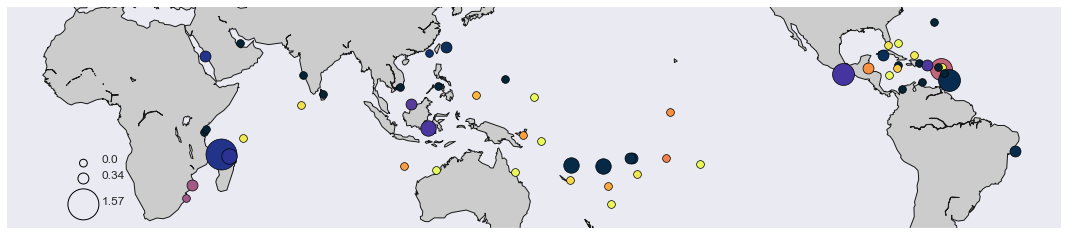

In [133]:
fig = plt.figure(figsize=(15, 5))
# Instantiate basemap
m = bm(llcrnrlon=-30,llcrnrlat=-37,urcrnrlon=340,urcrnrlat=37,projection='mill')
m.drawcoastlines()
#m.drawcountries()
m.fillcontinents()

#"""
# Convert longitude
SSlon[SSlon<0] = SSlon[SSlon<0]+360
xx,yy = m(SSlon,SSlat)
zz = [co.cm.thermal(Depletion[Location[i]]) for i in range(nlocs)]
# Plot points
[plt.scatter(x, y, c=z, edgecolor='black', linewidth=0.7, s=60*2**(con_potential[l]/max(con_potential.values[0])*4).astype(int), alpha=1, zorder=4) for x,y,z,l in zip(xx,yy,zz,Location)]

"""
for i in range(nlocs):
    if Location[i]=='Belize':
        plt.text(xx[i]-600000, yy[i], Location[i], ha='right', va='center')
    elif Location[i]=='Dutch Antilles Leeward':
        plt.text(xx[i]-600000, yy[i], Location[i], ha='right', va='center')
    elif con_potential[Location[i]][0]>0.9:
        plt.text(xx[i]+500000, yy[i], Location[i])
    else: 
        pass
"""
    
"""
for i in range(nlocs):
    if con_potential[Location[i]][0]>0.9:
        plt.text(xx[i]+500000, yy[i], Location[i])
    else: 
        pass



#"""



xoset = 700000
# Max conservation potential
plt.scatter(min(xx)-4000000,min(yy)-10000,s=max(60*2**(con_potential.values[0]/max(con_potential.values[0])*4).astype(int)),facecolors='none', edgecolors='black')
plt.text(min(xx)-4000000+xoset,min(yy)-10000,str(np.round(max(con_potential.values[0]),2)))

# Min conservation potential
plt.scatter(min(xx)-4000000,min(yy)+1600000,s=min(60*2**(con_potential.values[0]/max(con_potential.values[0])*4).astype(int)),facecolors='none', edgecolors='black')
plt.text(min(xx)-4000000+xoset,min(yy)+1600000,str(np.round(min(con_potential.values[0]),2)))

# Mean conservation potential
plt.scatter(min(xx)-4000000,min(yy)+1000000,s=np.mean(60*2**(con_potential.values[0]/max(con_potential.values[0])*4).astype(int)),facecolors='none', edgecolors='black')
plt.text(min(xx)-4000000+xoset,min(yy)+1000000,str(np.round(np.mean(con_potential.values[0]),2)))

fig.tight_layout()
plt.savefig('Figure_3a.pdf', bbox_inches='tight');


/Users/aaronmacneil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  This is separate from the ipykernel package so we can avoid doing imports until


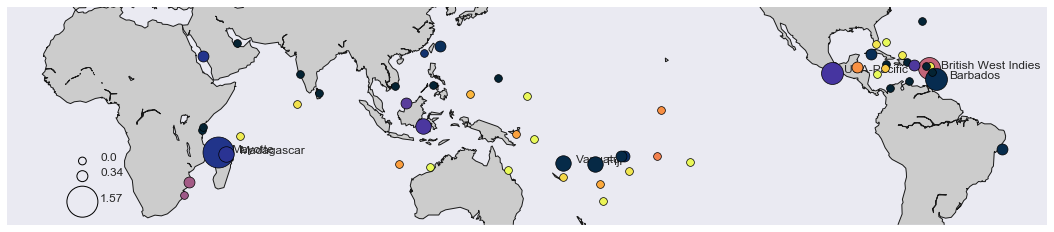

In [134]:
fig = plt.figure(figsize=(15, 5))
# Instantiate basemap
m = bm(llcrnrlon=-30,llcrnrlat=-37,urcrnrlon=340,urcrnrlat=37,projection='mill')
m.drawcoastlines()
#m.drawcountries()
m.fillcontinents()

#"""
# Convert longitude
SSlon[SSlon<0] = SSlon[SSlon<0]+360
xx,yy = m(SSlon,SSlat)
zz = [co.cm.thermal(Depletion[Location[i]]) for i in range(nlocs)]
# Plot points
[plt.scatter(x, y, c=z, edgecolor='black', linewidth=0.7, s=60*2**(con_potential[l]/max(con_potential.values[0])*4).astype(int), alpha=1, zorder=4) for x,y,z,l in zip(xx,yy,zz,Location)]

"""
for i in range(nlocs):
    if Location[i]=='Belize':
        plt.text(xx[i]-600000, yy[i], Location[i], ha='right', va='center')
    elif Location[i]=='Dutch Antilles Leeward':
        plt.text(xx[i]-600000, yy[i], Location[i], ha='right', va='center')
    elif con_potential[Location[i]][0]>0.9:
        plt.text(xx[i]+500000, yy[i], Location[i])
    else: 
        pass
"""
    
    
for i in range(nlocs):
    if con_potential[Location[i]][0]>0.9:
        plt.text(xx[i]+500000, yy[i], Location[i])
    else: 
        pass



#"""



xoset = 700000
# Max conservation potential
plt.scatter(min(xx)-4000000,min(yy)-10000,s=max(60*2**(con_potential.values[0]/max(con_potential.values[0])*4).astype(int)),facecolors='none', edgecolors='black')
plt.text(min(xx)-4000000+xoset,min(yy)-10000,str(np.round(max(con_potential.values[0]),2)))

# Min conservation potential
plt.scatter(min(xx)-4000000,min(yy)+1600000,s=min(60*2**(con_potential.values[0]/max(con_potential.values[0])*4).astype(int)),facecolors='none', edgecolors='black')
plt.text(min(xx)-4000000+xoset,min(yy)+1600000,str(np.round(min(con_potential.values[0]),2)))

# Mean conservation potential
plt.scatter(min(xx)-4000000,min(yy)+1000000,s=np.mean(60*2**(con_potential.values[0]/max(con_potential.values[0])*4).astype(int)),facecolors='none', edgecolors='black')
plt.text(min(xx)-4000000+xoset,min(yy)+1000000,str(np.round(np.mean(con_potential.values[0]),2)))

fig.tight_layout()
plt.savefig('Figure_3ax.pdf', bbox_inches='tight');


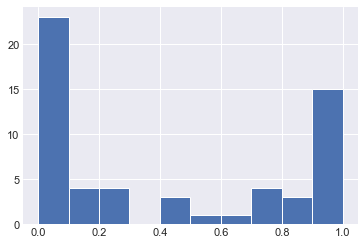

In [135]:
plt.hist(Depletion);

In [136]:
tmp = con_potential.T
tmp.columns = ['ConPo']
ConX = tmp.sort_values('ConPo', ascending=False).join(Depletion.T)
ConX.to_csv('ConPo.csv')

/Users/aaronmacneil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  This is separate from the ipykernel package so we can avoid doing imports until


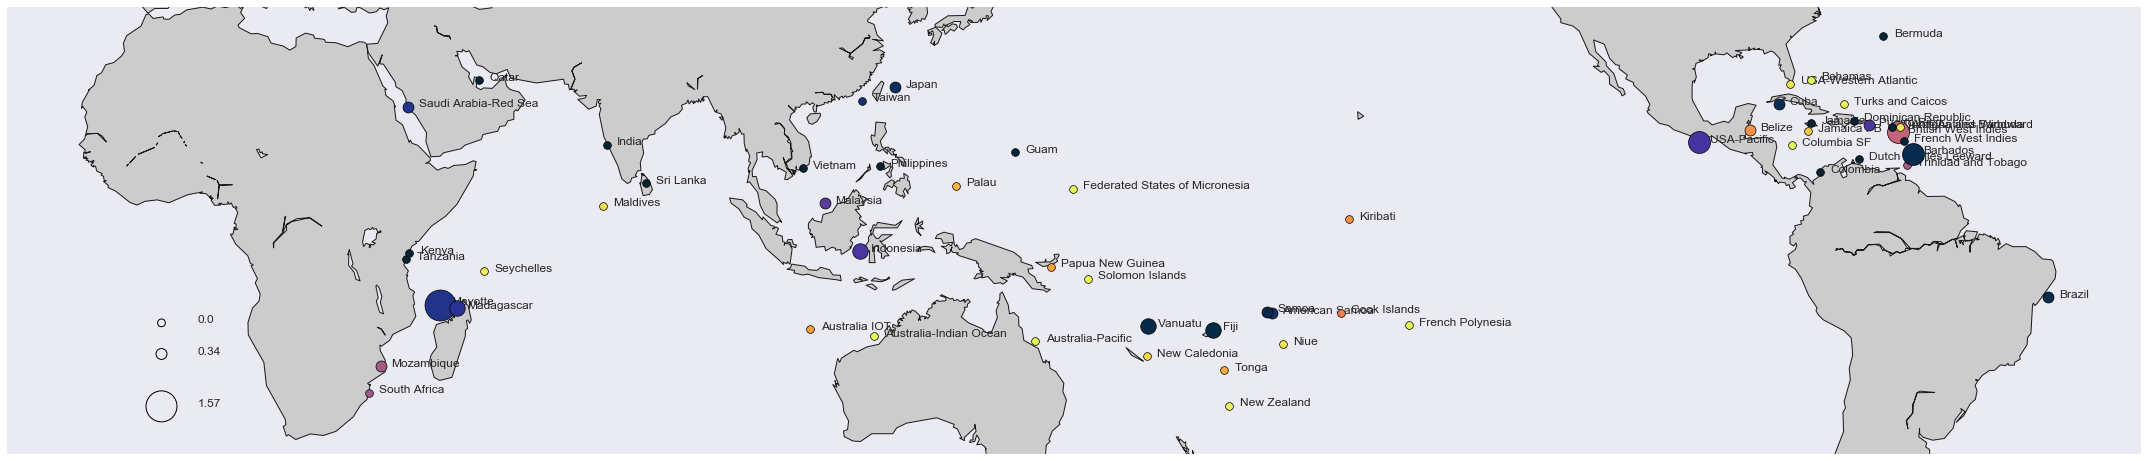

In [137]:
fig = plt.figure(figsize=(30, 20))
# Instantiate basemap
m = bm(llcrnrlon=-30,llcrnrlat=-37,urcrnrlon=340,urcrnrlat=37,projection='mill')
m.drawcoastlines()
#m.drawcountries()
m.fillcontinents()

#"""
# Convert longitude
SSlon[SSlon<0] = SSlon[SSlon<0]+360
xx,yy = m(SSlon,SSlat)
zz = [co.cm.thermal(Depletion[Location[i]]) for i in range(nlocs)]
# Plot points
[plt.scatter(x, y, c=z, edgecolor='black', linewidth=0.7, s=60*2**(con_potential[l]/max(con_potential.values[0])*4).astype(int), alpha=1, zorder=4) for x,y,z,l in zip(xx,yy,zz,Location)]

for i in range(nlocs):
    plt.text(xx[i]+200000, yy[i], Location[i])




#"""



xoset = 700000
# Max conservation potential
plt.scatter(min(xx)-4000000,min(yy)-10000,s=max(60*2**(con_potential.values[0]/max(con_potential.values[0])*4).astype(int)),facecolors='none', edgecolors='black')
plt.text(min(xx)-4000000+xoset,min(yy)-10000,str(np.round(max(con_potential.values[0]),2)))

# Min conservation potential
plt.scatter(min(xx)-4000000,min(yy)+1600000,s=min(60*2**(con_potential.values[0]/max(con_potential.values[0])*4).astype(int)),facecolors='none', edgecolors='black')
plt.text(min(xx)-4000000+xoset,min(yy)+1600000,str(np.round(min(con_potential.values[0]),2)))

# Mean conservation potential
plt.scatter(min(xx)-4000000,min(yy)+1000000,s=np.mean(60*2**(con_potential.values[0]/max(con_potential.values[0])*4).astype(int)),facecolors='none', edgecolors='black')
plt.text(min(xx)-4000000+xoset,min(yy)+1000000,str(np.round(np.mean(con_potential.values[0]),2)))

fig.tight_layout()
plt.savefig('Figure_all_nations.pdf', bbox_inches='tight');
